In [1]:
# 可以准备的预测相关变量：
# 一. 时序类：
# 1.农历日期或农历假日标签，2.当地的天气、平均温度、平均相对湿度，3.促销分类标签，4.陈列位置分类标签，5.除促销外的其他异常事件标签，
# 6.商店人流量，7.单品价格，8.单品销售额，9.采购订单历史记录（采购量、采购额），10.缺货历史记录（数量），
# 11.竞争对手价格、销售额、销量，12.与该单品相似商品的各种历史数据，13.门店营业天数及单品在销天数，14.地区相关门店的其他信息，
# 15.星期（对日序列）、月份、季度，16.距保质期末剩余天数，17.降雨量，18.日照时长、光照量，19.风力及风向，
# 二. 非时序类：
# 1.地区总人口、GDP、GNP、CPI、地区失业率、人均可支配收入等在统计局网站所能获取的经济指标，2.门店位置标签或门店编号、门店类型，
# 3.地区房屋均价、租金，4.单品所属部门类型或编号，5.地区相关门店的其他信息，6.商品相关属性，如生产商、品牌、材料、颜色、形状、尺寸，
# 7.某一时期地区能源价格如电价、油价等，

In [2]:
import time
t0 = time.clock()
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import fbprophet
Prophet = fbprophet.Prophet
from fbprophet.plot import plot_forecast_component
import numpy as np

In [3]:
# 导入并整理目标变量
data = pd.read_csv('test.csv')
data.rename(columns={data.columns[0]:'ds', data.columns[1]:'y'}, inplace=True)


data_train = data[data[data.columns[0]] <= '2017-12-31']
data_train[data_train.columns[0]] = pd.to_datetime(data_train[data_train.columns[0]]) # 为了后续的resample，将data_train中str格式的时间列转为datetime格式。
data_train = pd.DataFrame(data=list(data_train[data_train.columns[1]]),
                          index=data_train[data_train.columns[0]], columns=['y']) # 将data_train的index变为datetime，以便下一步将日序列重采样为周序列。
data_train_week = data_train.resample('W').sum() # 将index为日序列的dataframe降采样为周序列的dataframe
date_str_list = []
for i in range(len(data_train_week)):
    date_str_list.append(data_train_week.index[i].strftime('%Y-%m-%d')) # 为了后续做出符合fbprophet要求的datefrmae，将timestamp的时间列转成str
dictionary = {data_train_week.index.name: date_str_list,
              data_train_week.columns[0]: list(data_train_week[data_train_week.columns[0]])}
data_train_week = pd.DataFrame(data=dictionary)


data_test = data[data[data.columns[0]] > '2017-12-31']
data_test[data_test.columns[0]] = pd.to_datetime(data_test[data_test.columns[0]])
data_test = pd.DataFrame(data=list(data_test[data_test.columns[1]]),
                          index=data_test[data_test.columns[0]], columns=['y'])
data_test_week = data_test.resample('W').sum()
date_str_list = []
for i in range(len(data_test_week)):
    date_str_list.append(data_test_week.index[i].strftime('%Y-%m-%d'))
dictionary = {data_test_week.index.name: date_str_list,
              data_test_week.columns[0]: list(data_test_week[data_test_week.columns[0]])}
data_test_week = pd.DataFrame(data=dictionary)


fc = 20 # 设置预测步数
end = str(pd.date_range(start=data_train_week['ds'].max(), periods=fc+1, freq='W').max())
data_test_week = data_test_week[data_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


开始导入相关变量。注意：当相关变量不准确时，对预测结果影响很大。

In [4]:
# 导入并整理温度变量
temp = pd.read_csv('temp_day.csv', parse_dates=True)
temp.rename(columns={temp.columns[0]:'ds'}, inplace=True)
tempt = temp.loc[:,['ds', 'Tmean(C)']]


tempt_train = tempt[(tempt.index >= tempt[tempt.ds == '2013-01-01'].index[0]) 
                    & (tempt.index <= tempt[tempt.ds == '2017-12-31'].index[0])]
tempt_train[tempt_train.columns[0]] = pd.to_datetime(tempt_train[tempt_train.columns[0]])
tempt_train = pd.DataFrame(data=list(tempt_train[tempt_train.columns[1]]), 
                          index=tempt_train[tempt_train.columns[0]], columns=['Tmean(C)'])
tempt_train_week = tempt_train.resample('W').mean()
pydate_array = tempt_train_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {tempt_train_week.index.name: list(date_str_array),
              tempt_train_week.columns[0]: list(tempt_train_week[tempt_train_week.columns[0]])}
tempt_train_week = pd.DataFrame(data=dictionary)


tempt_test = tempt[(tempt.index > tempt[tempt.ds == '2017-12-31'].index[0]) 
                   & (tempt.index <= tempt[tempt.ds == '2018-06-01'].index[0])]
tempt_test[tempt_test.columns[0]] = pd.to_datetime(tempt_test[tempt_test.columns[0]])
tempt_test = pd.DataFrame(data=list(tempt_test[tempt_test.columns[1]]), 
                          index=tempt_test[tempt_test.columns[0]], columns=['Tmean(C)'])
tempt_test_week = tempt_test.resample('W').mean()
pydate_array = tempt_test_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {tempt_test_week.index.name: list(date_str_array),
              tempt_test_week.columns[0]: list(tempt_test_week[tempt_test_week.columns[0]])}
tempt_test_week = pd.DataFrame(data=dictionary)
tempt_test_week = tempt_test_week[tempt_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# 导入并整理湿度变量
temp = pd.read_csv('temp_day.csv', parse_dates=True)
temp.rename(columns={temp.columns[0]:'ds'}, inplace=True)
RH = temp.loc[:,['ds', 'RHmean(%)']]
RH = RH.interpolate(method='linear') # 因为RH中有NaN，进入fit时会报错，所以需填充数值。


RH_train = RH[(RH.index >= RH[RH.ds == '2013-01-01'].index[0]) 
                    & (RH.index <= RH[RH.ds == '2017-12-31'].index[0])]
RH_train[RH_train.columns[0]] = pd.to_datetime(RH_train[RH_train.columns[0]])
RH_train = pd.DataFrame(data=list(RH_train[RH_train.columns[1]]), 
                          index=RH_train[RH_train.columns[0]], columns=['RHmean(%)'])
RH_train_week = RH_train.resample('W').mean()
pydate_array = RH_train_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {RH_train_week.index.name: list(date_str_array),
              RH_train_week.columns[0]: list(RH_train_week[RH_train_week.columns[0]])}
RH_train_week = pd.DataFrame(data=dictionary)


RH_test = RH[(RH.index > RH[RH.ds == '2017-12-31'].index[0]) 
                   & (RH.index <= RH[RH.ds == '2018-06-01'].index[0])]
RH_test[RH_test.columns[0]] = pd.to_datetime(RH_test[RH_test.columns[0]])
RH_test = pd.DataFrame(data=list(RH_test[RH_test.columns[1]]), 
                          index=RH_test[RH_test.columns[0]], columns=['RHmean(%)'])
RH_test_week = RH_test.resample('W').mean()
pydate_array = RH_test_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {RH_test_week.index.name: list(date_str_array),
              RH_test_week.columns[0]: list(RH_test_week[RH_test_week.columns[0]])}
RH_test_week = pd.DataFrame(data=dictionary)
RH_test_week = RH_test_week[RH_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
# 导入并整理降雨量变量
rain = pd.read_csv('rain_day.csv', parse_dates=True)
rain.rename(columns={rain.columns[0]:'ds', rain.columns[1]:'rain'}, inplace=True)


rain_train = rain[(rain.index >= rain[rain.ds == '2013-01-01'].index[0]) 
                    & (rain.index <= rain[rain.ds == '2017-12-31'].index[0])]
rain_train[rain_train.columns[0]] = pd.to_datetime(rain_train[rain_train.columns[0]])
rain_train = pd.DataFrame(data=list(rain_train[rain_train.columns[1]]), 
                          index=rain_train[rain_train.columns[0]], columns=['rain'])
rain_train_week = rain_train.resample('W').mean()
pydate_array = rain_train_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {rain_train_week.index.name: list(date_str_array),
              rain_train_week.columns[0]: list(rain_train_week[rain_train_week.columns[0]])}
rain_train_week = pd.DataFrame(data=dictionary)
rain_train_week.rename(columns={rain_train_week.columns[1]:'rain'}, inplace=True)


rain_test = rain[(rain.index > rain[rain.ds == '2017-12-31'].index[0]) 
                   & (rain.index <= rain[rain.ds == '2018-06-01'].index[0])]
rain_test[rain_test.columns[0]] = pd.to_datetime(rain_test[rain_test.columns[0]])
rain_test = pd.DataFrame(data=list(rain_test[rain_test.columns[1]]), 
                          index=rain_test[rain_test.columns[0]], columns=['rain'])
rain_test_week = rain_test.resample('W').mean()
pydate_array = rain_test_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {rain_test_week.index.name: list(date_str_array),
              rain_test_week.columns[0]: list(rain_test_week[rain_test_week.columns[0]])}
rain_test_week = pd.DataFrame(data=dictionary)
rain_test_week = rain_test_week[rain_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# 导入并整理日照量变量
sun = pd.read_csv('sun_day.csv', parse_dates=True)
sun.rename(columns={sun.columns[0]:'ds', sun.columns[1]:'sun'}, inplace=True)


sun_train = sun[(sun.index >= sun[sun.ds == '2013-01-01'].index[0]) 
                    & (sun.index <= sun[sun.ds == '2017-12-31'].index[0])]
sun_train[sun_train.columns[0]] = pd.to_datetime(sun_train[sun_train.columns[0]])
sun_train = pd.DataFrame(data=list(sun_train[sun_train.columns[1]]), 
                          index=sun_train[sun_train.columns[0]], columns=['sun'])
sun_train_week = sun_train.resample('W').mean()
pydate_array = sun_train_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {sun_train_week.index.name: list(date_str_array),
              sun_train_week.columns[0]: list(sun_train_week[sun_train_week.columns[0]])}
sun_train_week = pd.DataFrame(data=dictionary)


sun_test = sun[(sun.index > sun[sun.ds == '2017-12-31'].index[0]) 
                   & (sun.index <= sun[sun.ds == '2018-06-01'].index[0])]
sun_test[sun_test.columns[0]] = pd.to_datetime(sun_test[sun_test.columns[0]])
sun_test = pd.DataFrame(data=list(sun_test[sun_test.columns[1]]), 
                          index=sun_test[sun_test.columns[0]], columns=['sun'])
sun_test_week = sun_test.resample('W').mean()
pydate_array = sun_test_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {sun_test_week.index.name: list(date_str_array),
              sun_test_week.columns[0]: list(sun_test_week[sun_test_week.columns[0]])}
sun_test_week = pd.DataFrame(data=dictionary)
sun_test_week = sun_test_week[sun_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# 导入并整理风力变量
wind = pd.read_csv('wind_day.csv', parse_dates=True)
wind.rename(columns={wind.columns[0]:'ds', wind.columns[2]:'wind'}, inplace=True)
wind.drop(columns=[wind.columns[1]], inplace=True)


wind_train = wind[(wind.index >= wind[wind.ds == '2013-01-01'].index[0]) 
                    & (wind.index <= wind[wind.ds == '2017-12-31'].index[0])]
wind_train[wind_train.columns[0]] = pd.to_datetime(wind_train[wind_train.columns[0]])
wind_train = pd.DataFrame(data=list(wind_train[wind_train.columns[1]]), 
                          index=wind_train[wind_train.columns[0]], columns=['wind'])
wind_train_week = wind_train.resample('W').mean()
pydate_array = wind_train_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {wind_train_week.index.name: list(date_str_array),
              wind_train_week.columns[0]: list(wind_train_week[wind_train_week.columns[0]])}
wind_train_week = pd.DataFrame(data=dictionary)


wind_test = wind[(wind.index > wind[wind.ds == '2017-12-31'].index[0]) 
                   & (wind.index <= wind[wind.ds == '2018-06-01'].index[0])]
wind_test[wind_test.columns[0]] = pd.to_datetime(wind_test[wind_test.columns[0]])
wind_test = pd.DataFrame(data=list(wind_test[wind_test.columns[1]]), 
                          index=wind_test[wind_test.columns[0]], columns=['wind'])
wind_test_week = wind_test.resample('W').mean()
pydate_array = wind_test_week.index.to_pydatetime()
date_str_array = np.vectorize(lambda x: x.strftime('%Y-%m-%d'))(pydate_array)
dictionary = {wind_test_week.index.name: list(date_str_array),
              wind_test_week.columns[0]: list(wind_test_week[wind_test_week.columns[0]])}
wind_test_week = pd.DataFrame(data=dictionary)
wind_test_week = wind_test_week[wind_test_week['ds'] <= end]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
# 设置自定义节假日。注意：当时序为周序列时，自定义节假日时间段与周时间段匹配时，节假日项才参与计算。
# 'lower_window': -n，表示从“指定日期减n天”开始计算假日分量；upper_window': n，表示假日分量计算到”指定日期加n天“；0表示指定日期当天。
holidays_df = pd.DataFrame({'holiday': 'holidays_df',
                            'ds': pd.to_datetime(['2013-01-06', '2013-03-08', '2013-06-01',
                                                  '2013-09-10', '2013-11-11', '2013-12-12',
                                                  '2014-01-06', '2014-03-08', '2014-06-01',
                                                  '2014-09-10', '2014-11-11', '2014-12-12',
                                                  '2015-01-06', '2015-03-08', '2015-06-01',
                                                  '2015-09-10', '2015-11-11', '2015-12-12',
                                                  '2016-01-06', '2016-03-08', '2016-06-01',
                                                  '2016-09-10', '2016-11-11', '2016-12-12',
                                                  '2017-01-06', '2017-03-08', '2017-06-01',
                                                  '2017-09-10', '2017-11-11', '2017-12-12',
                                                  '2018-01-06', '2018-03-08', '2018-06-01',
                                                  '2018-09-10', '2018-11-11', '2018-12-12', ]),
                            'lower_window': -1,
                            'upper_window': 1})

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8890.750614195844,
  11654.35999060316,
  8281.239402441151,
  9620.276066005448,
  7982.561577284325,
  8594.347146943108,
  10048.09047463278,
  11221.60430130065,
  10029.529478453236,
  11170.578828348509,
  8622.623985710889,
  9347.438000474041,
  10238.523625955519,
  11296.597401332325,
  7530.634607698186,
  9586.635987540385,
  9395.12017562754,
  10006.130076122083,
  8592.351745950595,
  9063.428979714936],
 array([8798.49111779, 8847.44410173, 8896.39708567, 8945.35006962,
        8994.30305356, 9043.2560375 , 9092.20902145, 9141.16200539,
        9190.11498933, 9239.06797328, 9288.02095722, 9336.97394116,
        9385.92692511, 9434.87990905, 9483.83289299, 9532.78587694,
        9581.73886088, 9630.69184482, 9679.64482877, 9728.59781271]),
 array([33.41722482,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

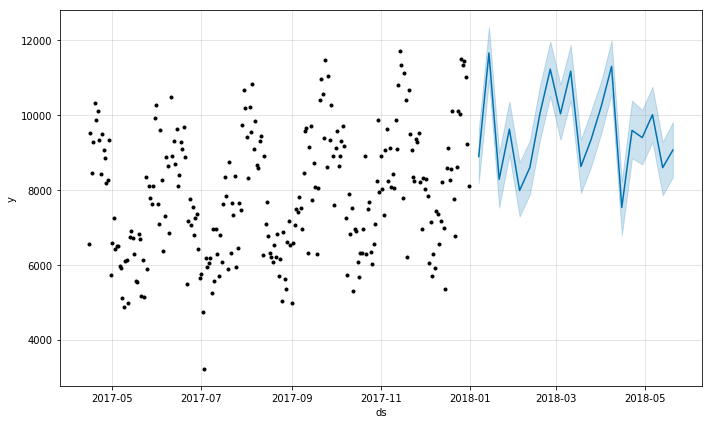

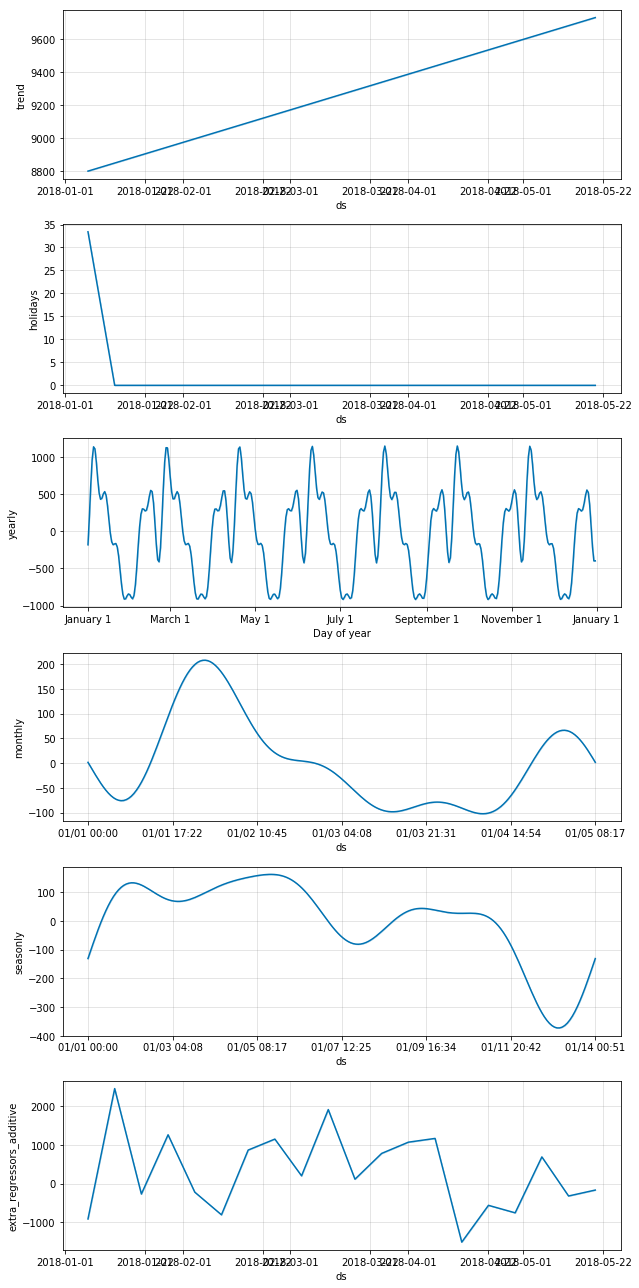

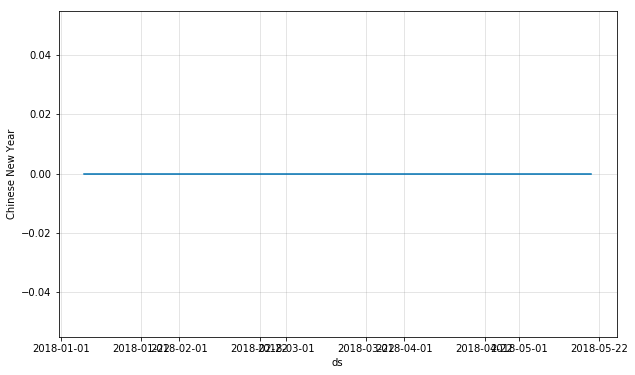

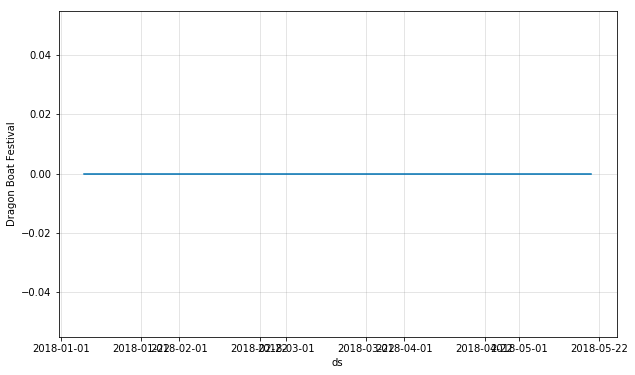

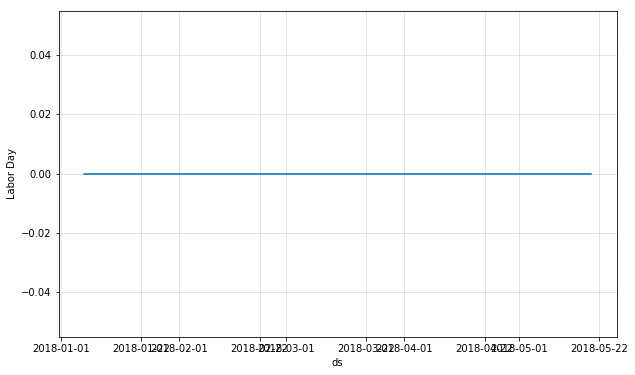

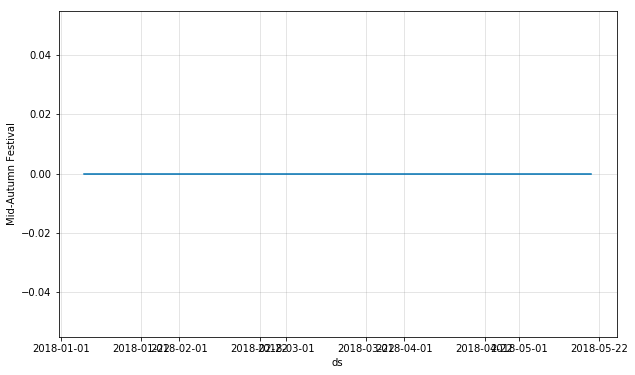

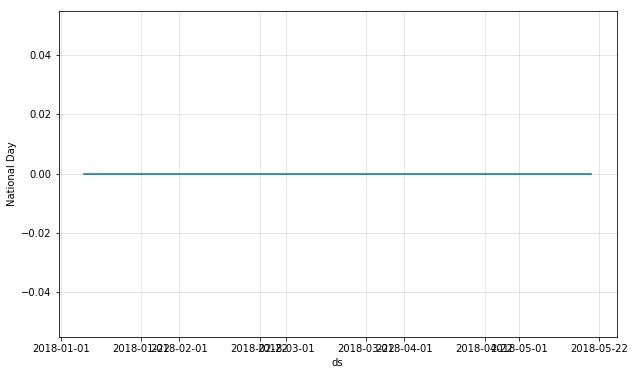

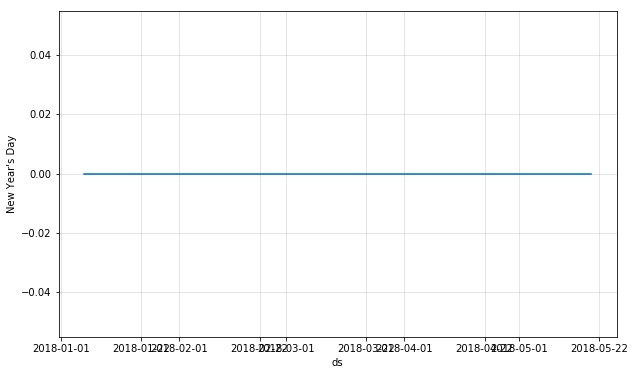

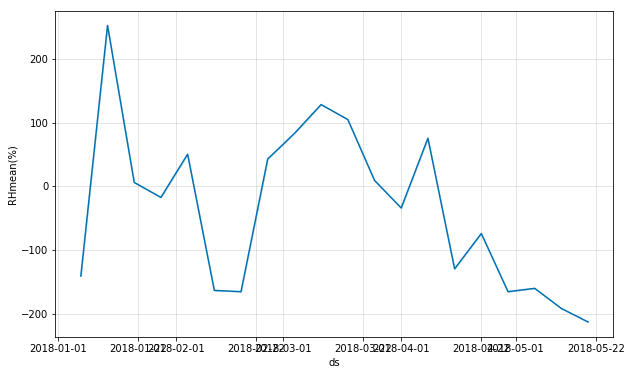

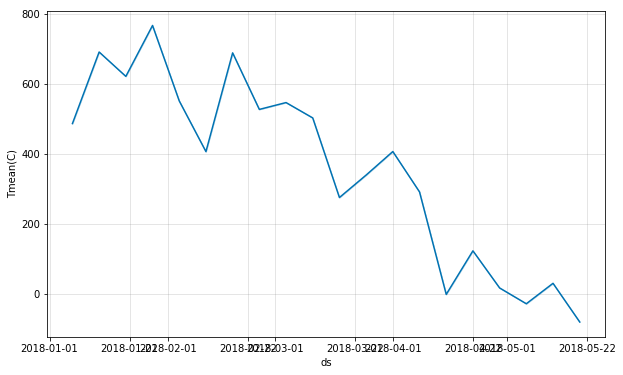

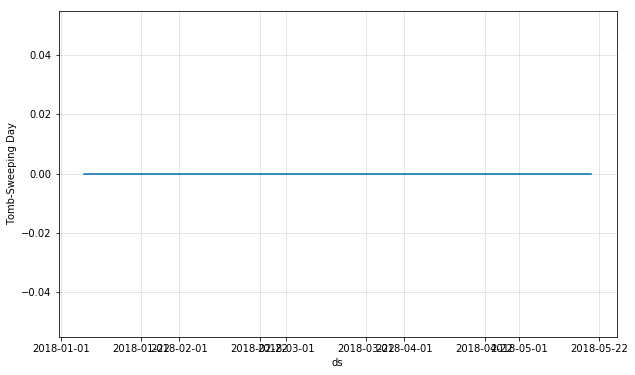

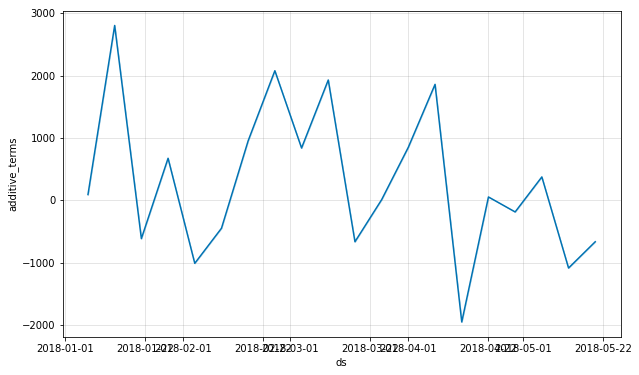

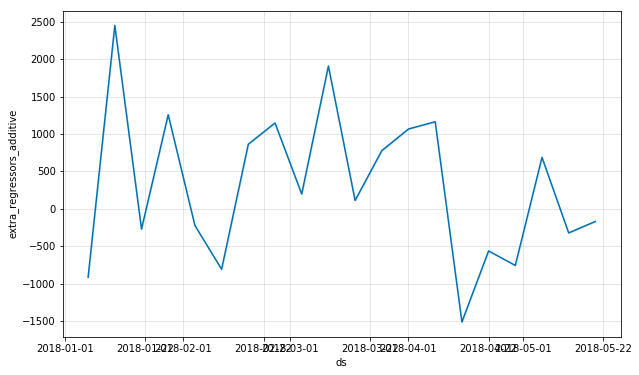

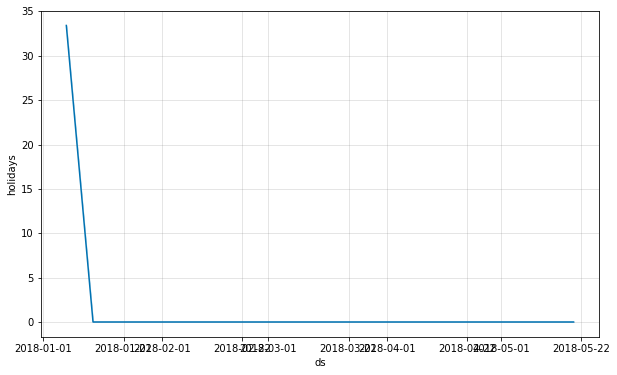

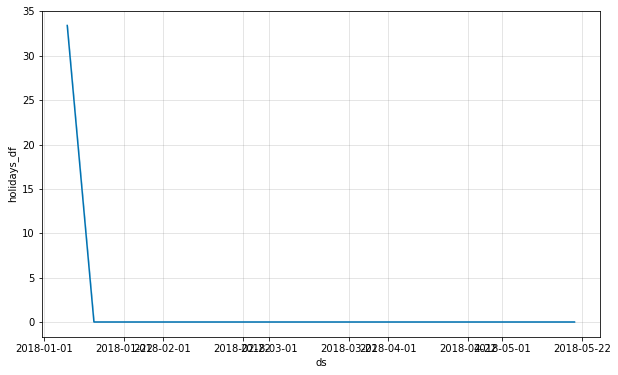

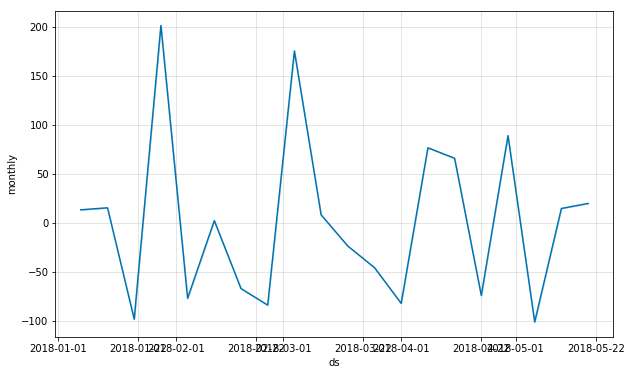

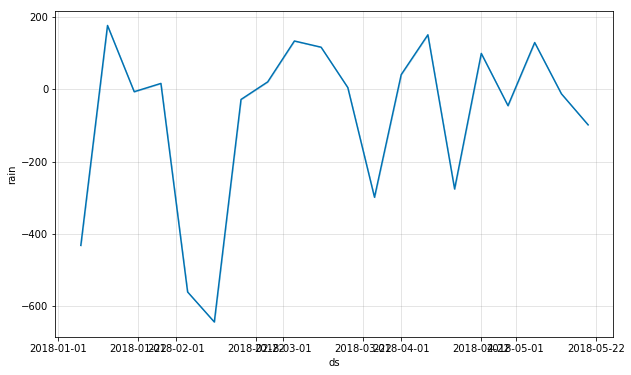

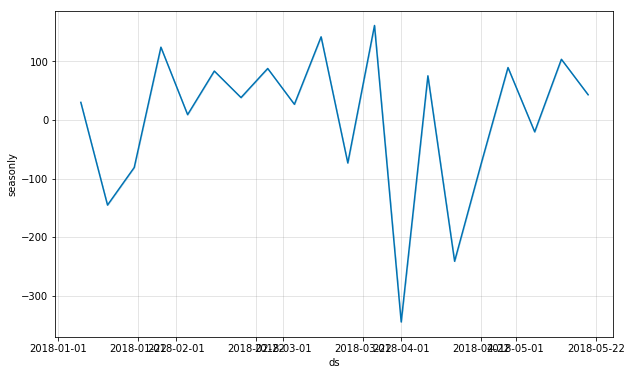

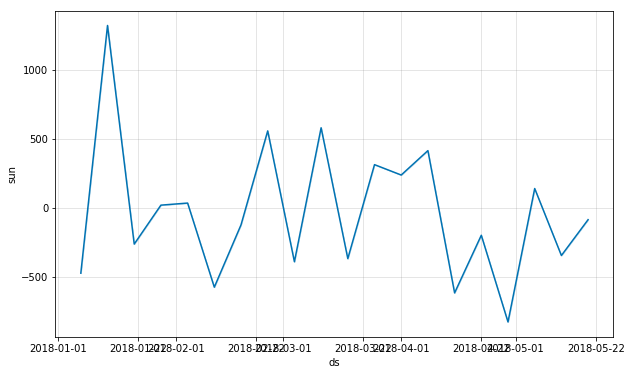

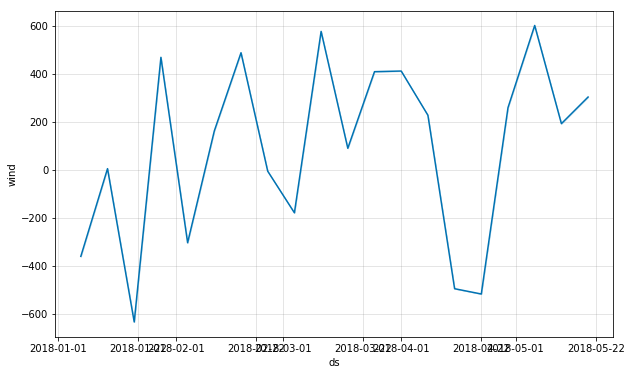

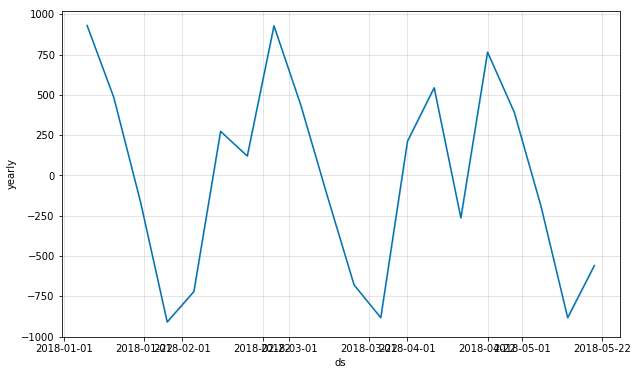

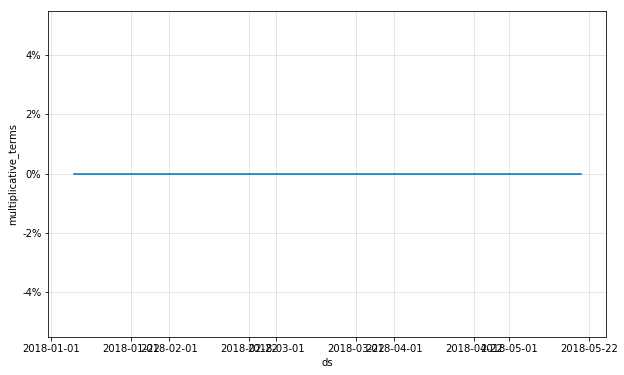

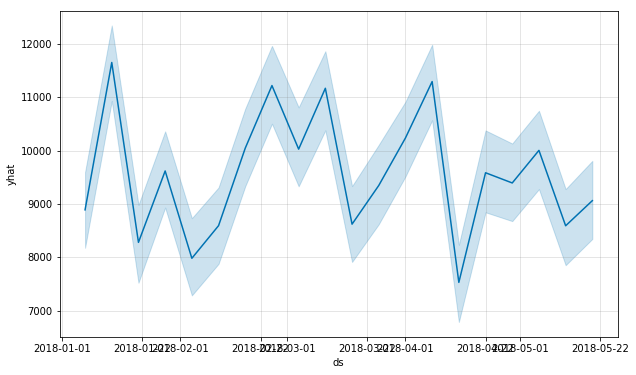

In [10]:
def prophet_func_111(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，所有非线性项均以加法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m111 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m111.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m111.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='additive')
    m111.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='additive')
    m111.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='additive')
    # 设置add_regressor中相关变量信息但不赋值
    m111.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='additive')
    m111.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='additive')
    m111.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='additive')
    m111.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='additive')
    m111.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='additive')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m111.fit(df_train)
    future = m111.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future111 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future111
    forecast111 = m111.predict(future111)
    # 输出图形及数值预测结果
    fig1 = m111.plot(forecast111)
    fig2 = m111.plot_components(forecast111)
    for i in range(6, 67, 3):
        plot_forecast_component(m111, forecast111, forecast111.columns[i])

    prophet_amou = forecast111['yhat'].values
    trend_amou = forecast111['trend'].values
    holiday_amou = forecast111['holidays'].values
    seasonality_amou = forecast111['yearly'].values + forecast111['seasonly'].values + forecast111['monthly'].values
    relative_amou = forecast111['extra_regressors_additive'].values
    
    if False not in (prophet_amou - trend_amou - holiday_amou - seasonality_amou - relative_amou < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else:
        return None

predict_result = []
predict_result = prophet_func_111()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8922.103204678679,
  11935.659056191564,
  8079.494351682798,
  9492.072495532033,
  7669.435328529358,
  8391.963428438905,
  10033.309649534638,
  11490.031744808972,
  10204.88959671521,
  11353.433454745275,
  8402.630937244825,
  9136.106650227952,
  10247.631273364967,
  11470.083552560043,
  7173.128165392912,
  9718.123465732207,
  9343.28785064925,
  9952.362634731797,
  8131.928857541071,
  8754.312128471141],
 array([8771.91306546, 8819.12337611, 8866.33368676, 8913.5439974 ,
        8960.75430805, 9007.96461869, 9055.17492934, 9102.38523999,
        9149.59555063, 9196.80586128, 9244.01617193, 9291.22648257,
        9338.43679322, 9385.64710386, 9432.85741451, 9480.06772516,
        9527.2780358 , 9574.48834645, 9621.6986571 , 9668.90896774]),
 array([0.00691761, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.      

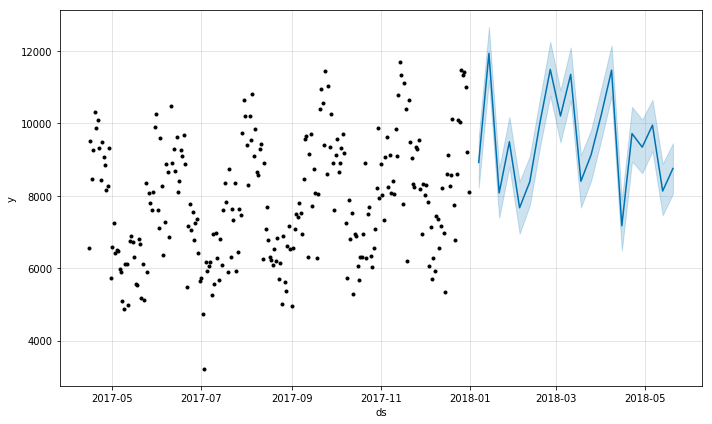

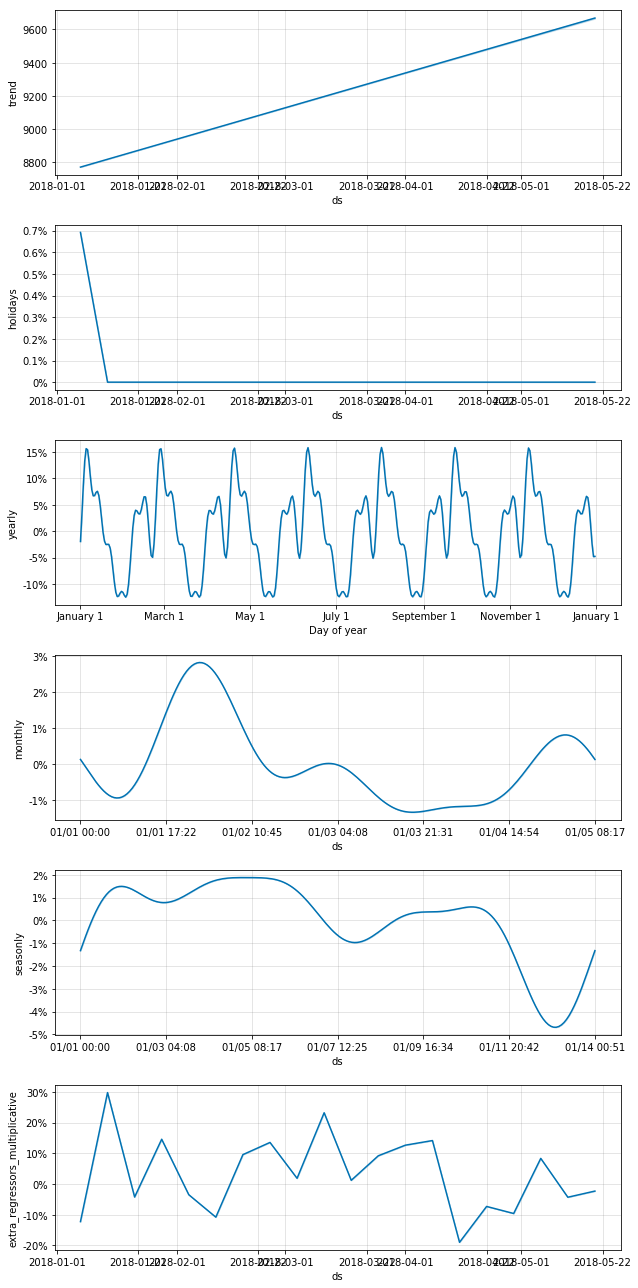

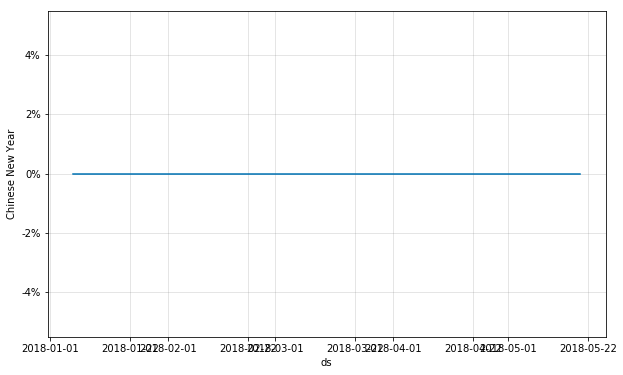

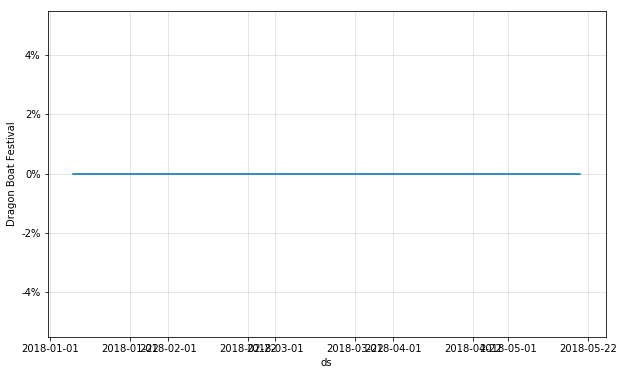

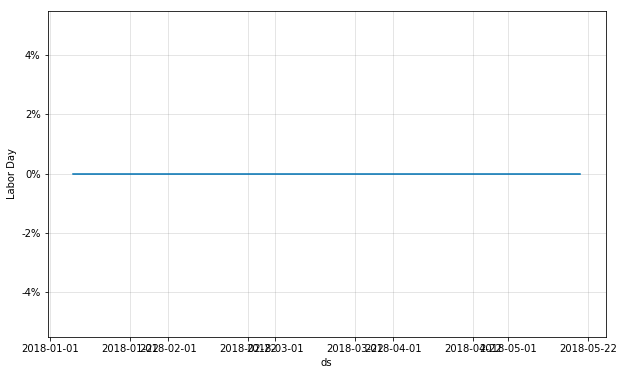

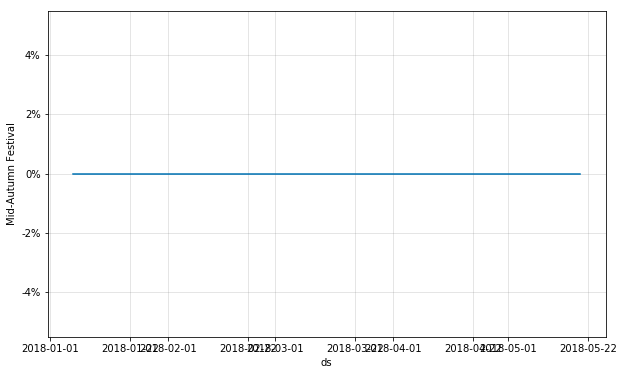

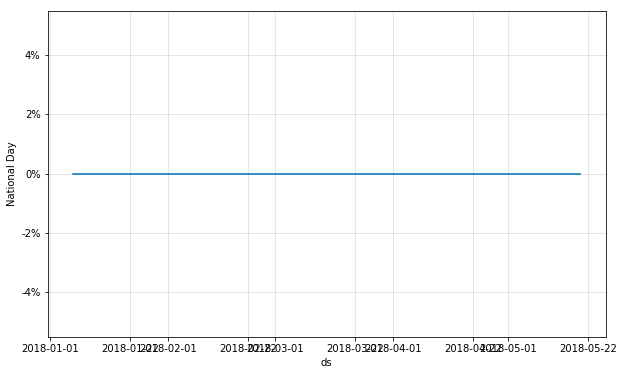

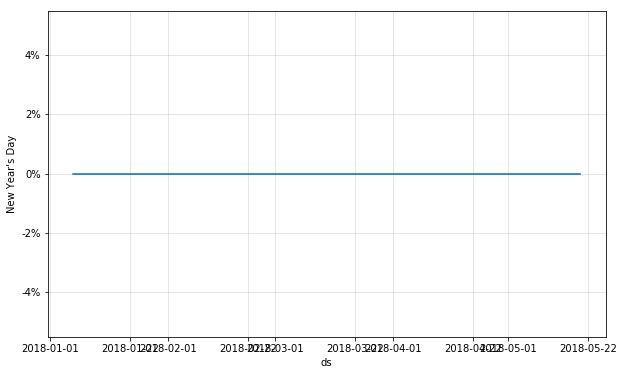

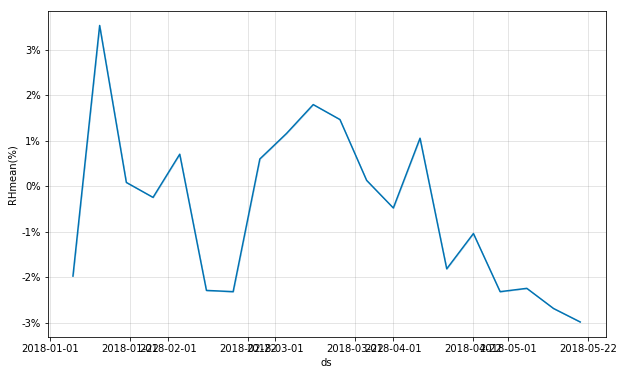

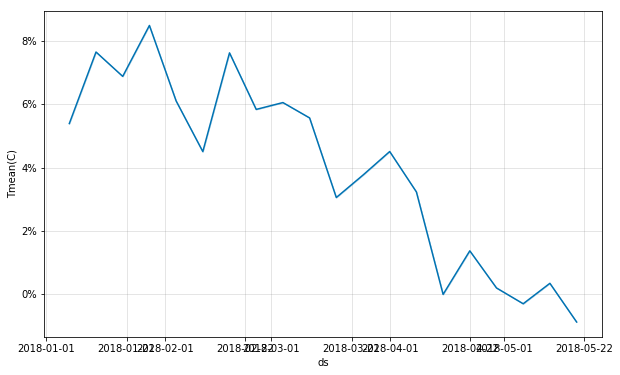

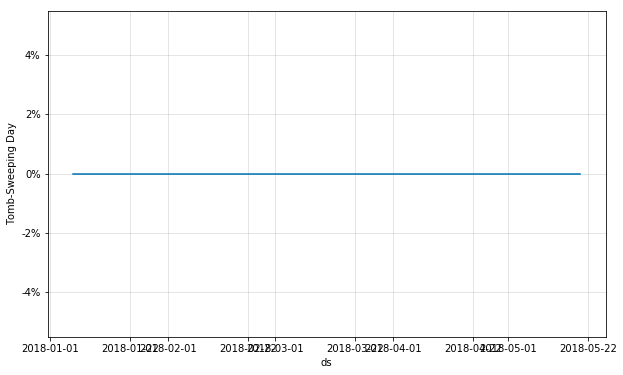

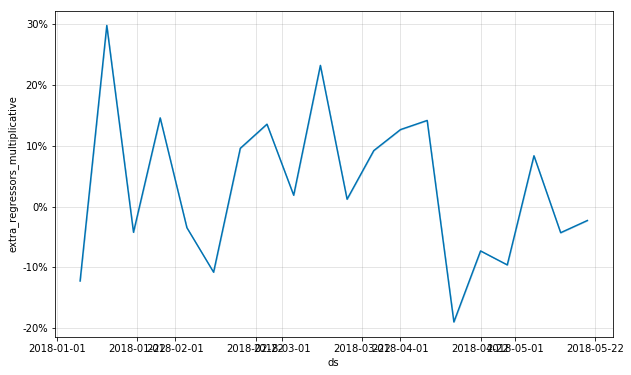

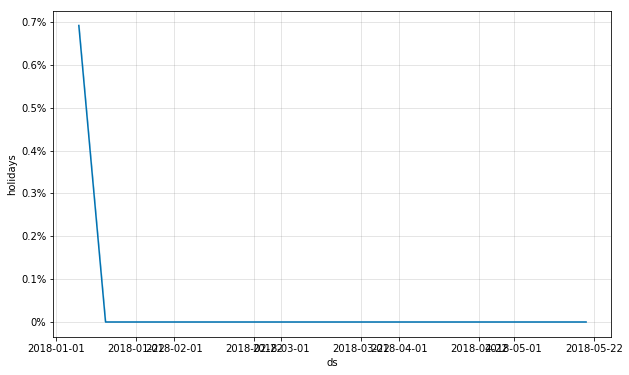

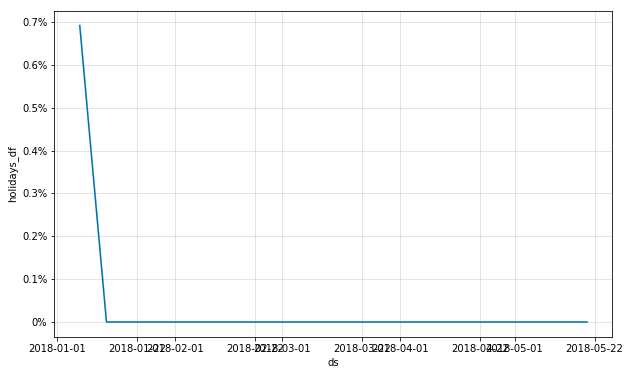

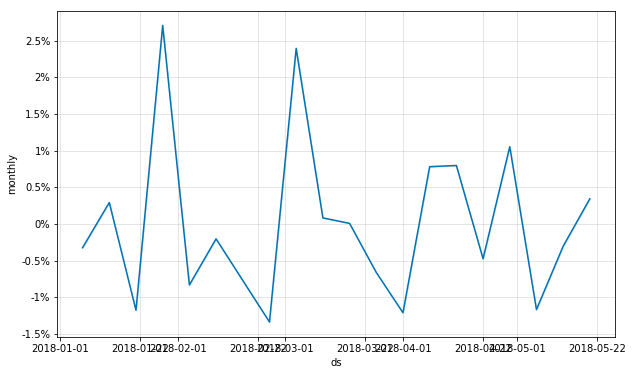

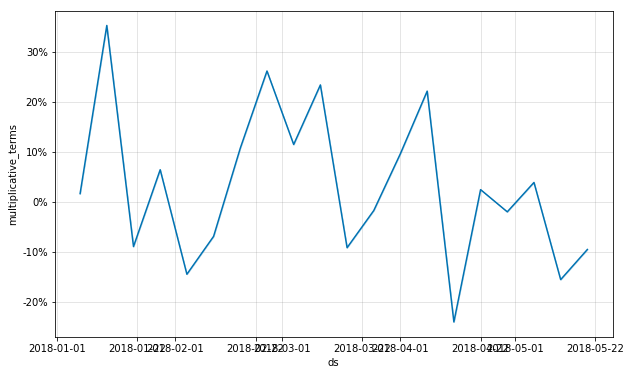

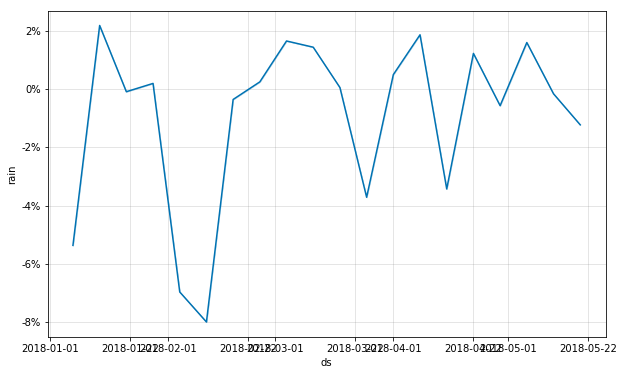

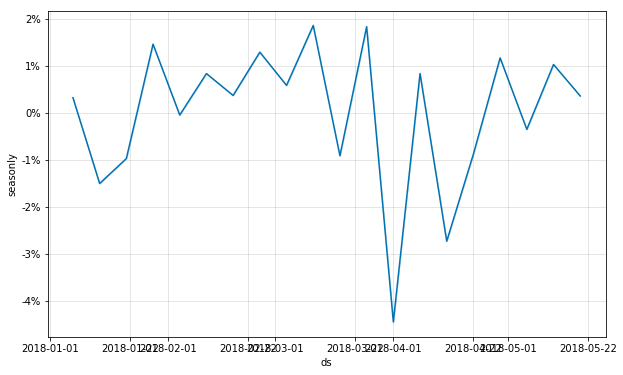

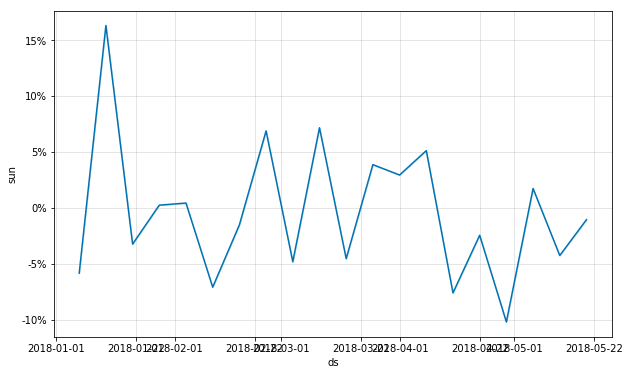

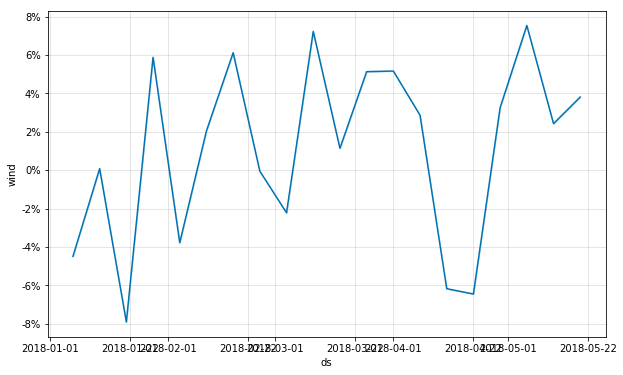

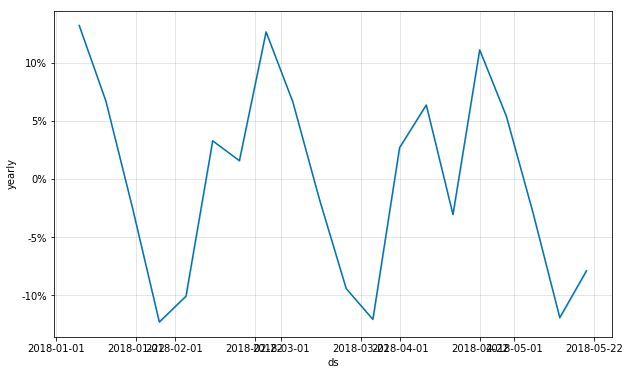

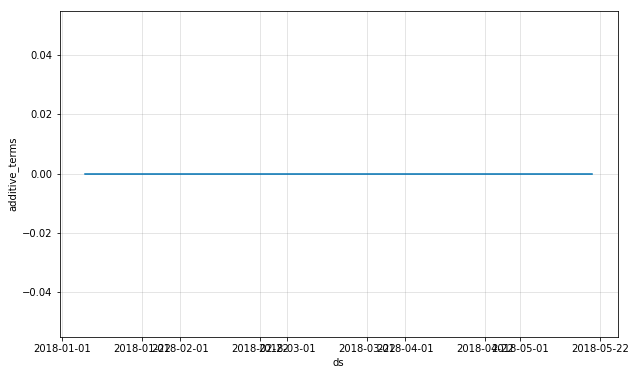

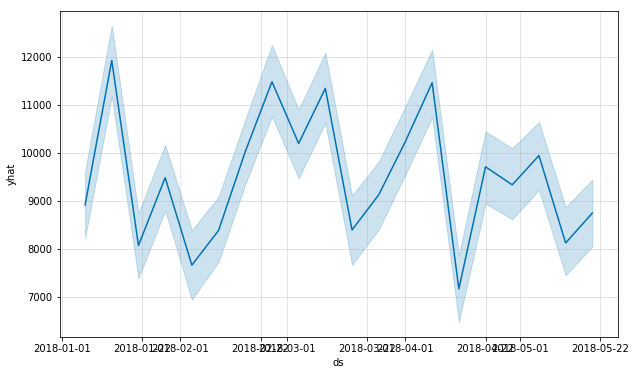

In [11]:
def prophet_func_222(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，所有非线性项均以乘法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m222 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m222.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m222.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='multiplicative')
    m222.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='multiplicative')
    m222.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='multiplicative')
    # 设置add_regressor中相关变量信息但不赋值
    m222.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m222.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m222.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m222.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m222.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='multiplicative')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m222.fit(df_train)
    future = m222.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future222 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future222
    forecast222 = m222.predict(future222)
    # 输出图形及数值预测结果
    fig1 = m222.plot(forecast222)
    fig2 = m222.plot_components(forecast222)
    for i in range(6, 67, 3):
        plot_forecast_component(m222, forecast222, forecast222.columns[i])

    prophet_amou = forecast222['yhat'].values
    trend_amou = forecast222['trend'].values
    holiday_amou = forecast222['holidays'].values
    seasonality_amou = forecast222['yearly'].values + forecast222['seasonly'].values + forecast222['monthly'].values
    relative_amou = forecast222['extra_regressors_multiplicative'].values
    
    if False not in (prophet_amou - (trend_amou * (1 + holiday_amou + seasonality_amou + relative_amou)) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_222()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8812.754159441012,
  12098.766873204806,
  8447.11007276369,
  9987.850874656942,
  8112.597733769034,
  8528.248788927418,
  10077.234925524686,
  11391.372925015092,
  10131.290634157265,
  11564.749721653956,
  8811.455758957536,
  9585.67586765042,
  10488.16995168424,
  11406.239922490076,
  7155.740676538891,
  9446.564157749579,
  9191.457783234258,
  10108.583538744562,
  8546.573798854939,
  8962.101073668278],
 array([8788.12756418, 8836.20128619, 8884.27500819, 8932.3487302 ,
        8980.42245221, 9028.49617421, 9076.56989622, 9124.64361822,
        9172.71734023, 9220.79106223, 9268.86478424, 9316.93850624,
        9365.01222825, 9413.08595026, 9461.15967226, 9509.23339427,
        9557.30711627, 9605.38083828, 9653.45456028, 9701.52828229]),
 array([49.6625701,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.     

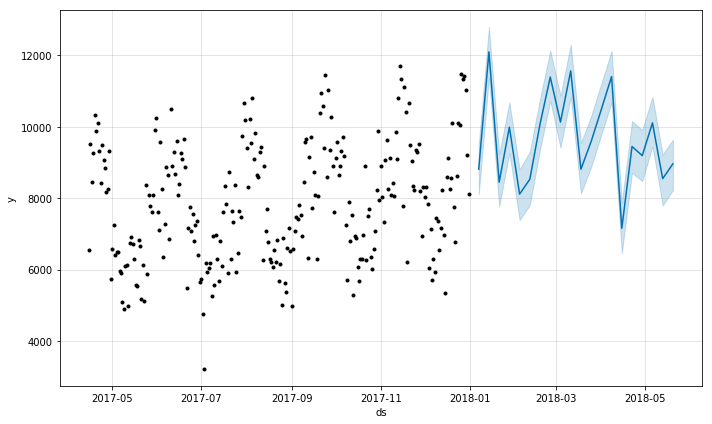

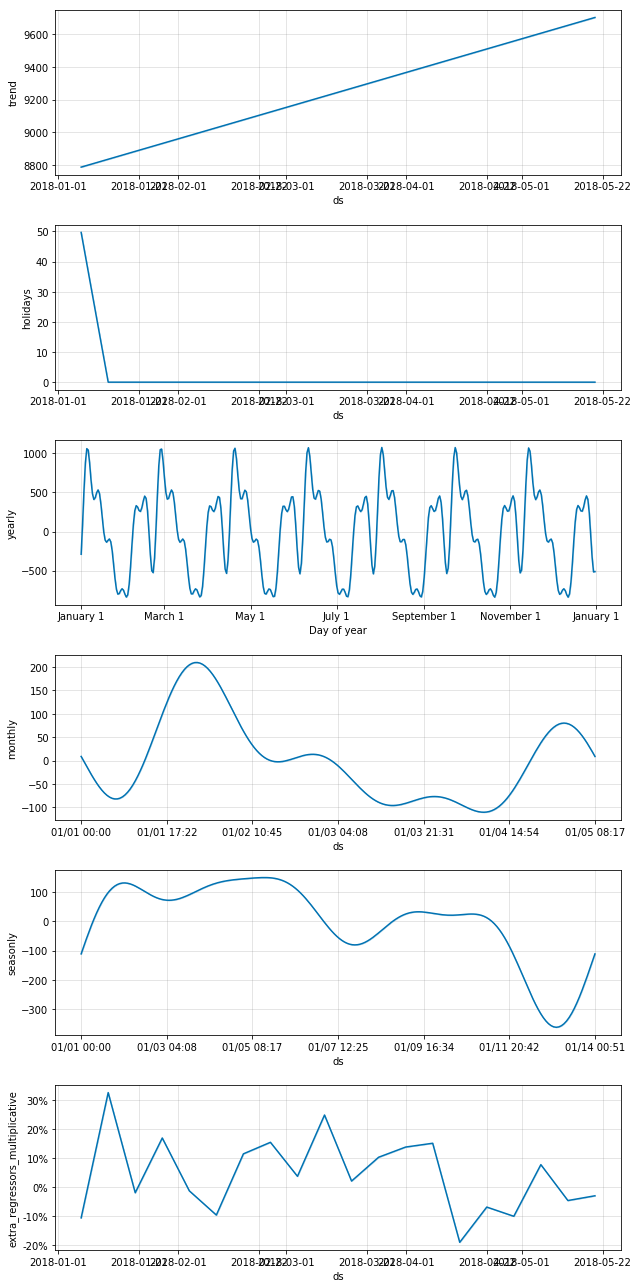

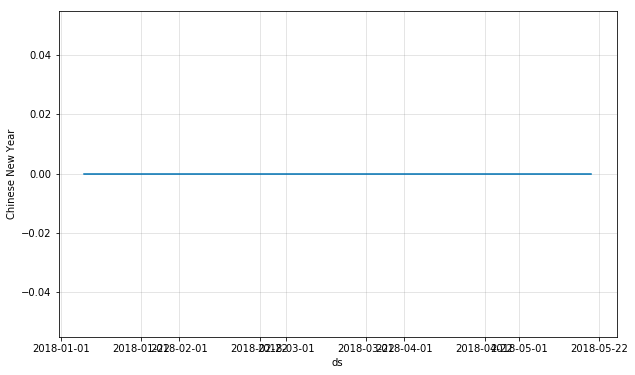

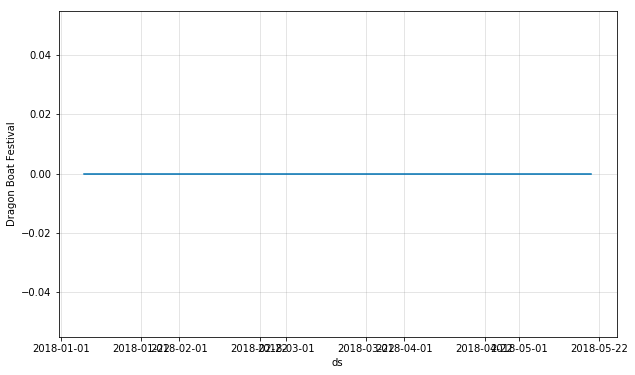

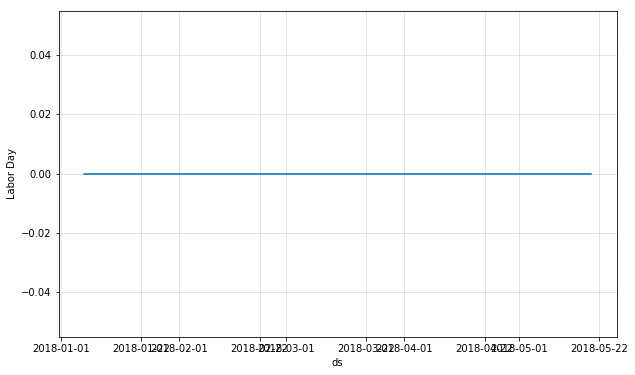

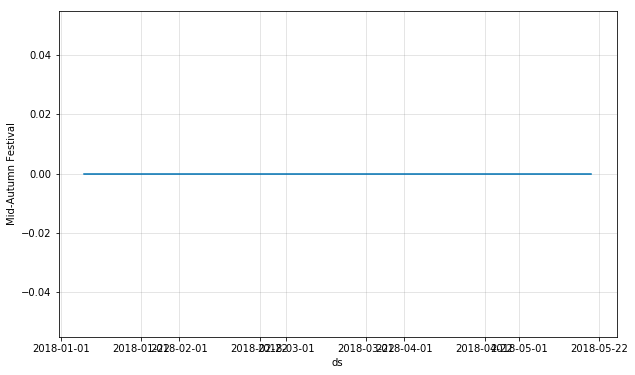

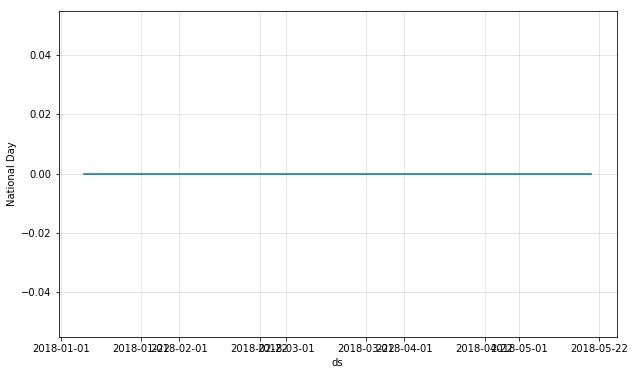

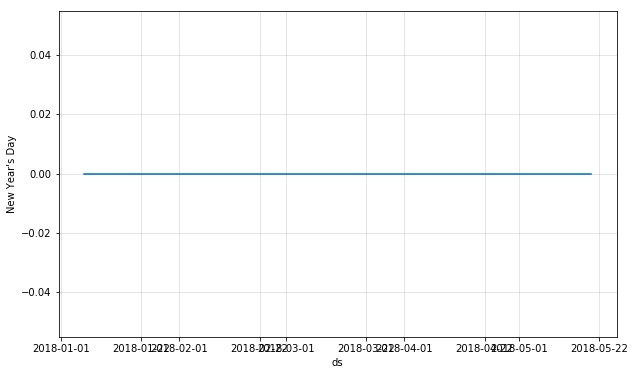

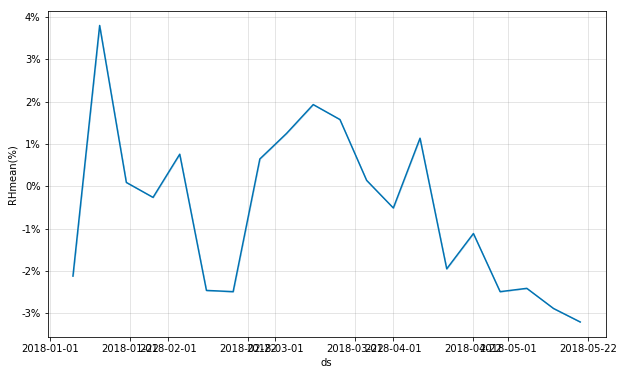

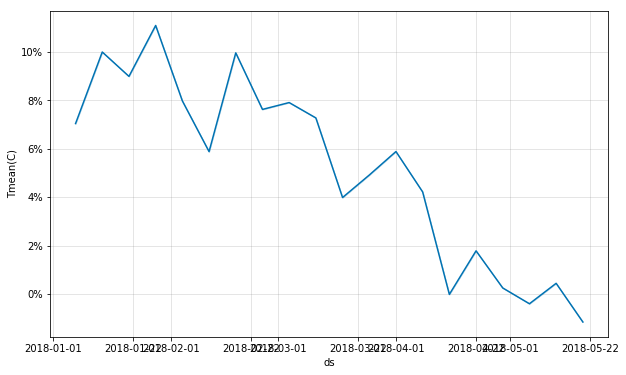

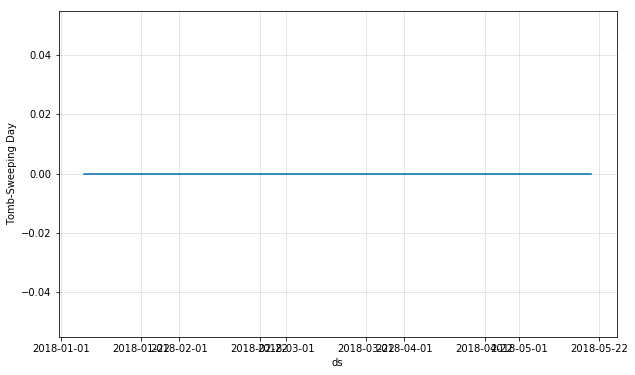

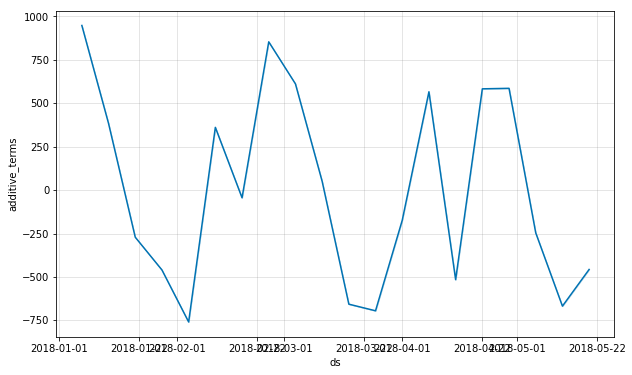

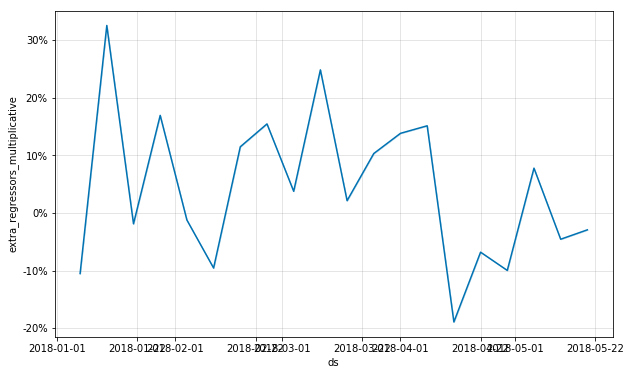

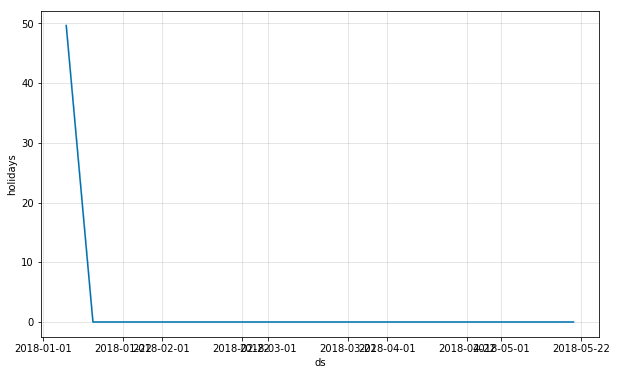

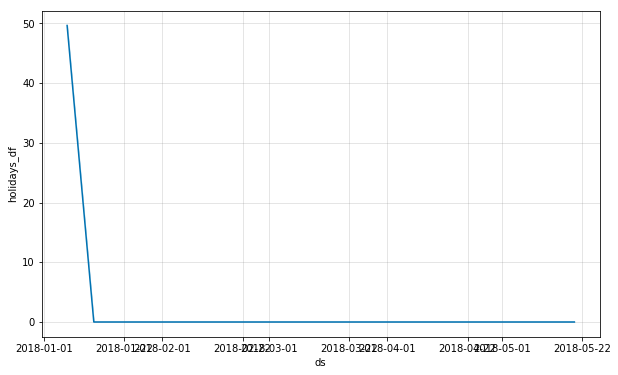

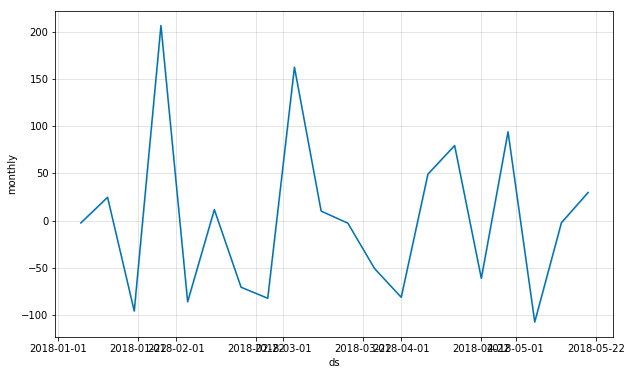

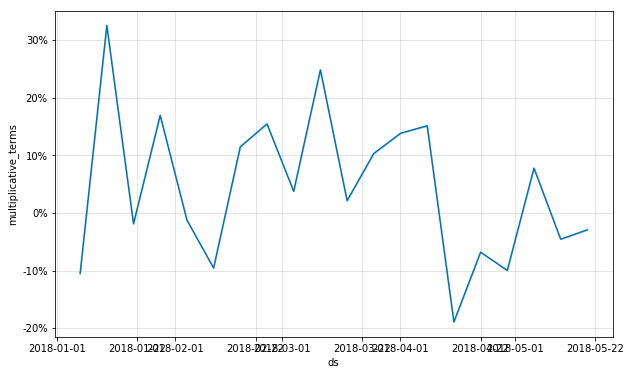

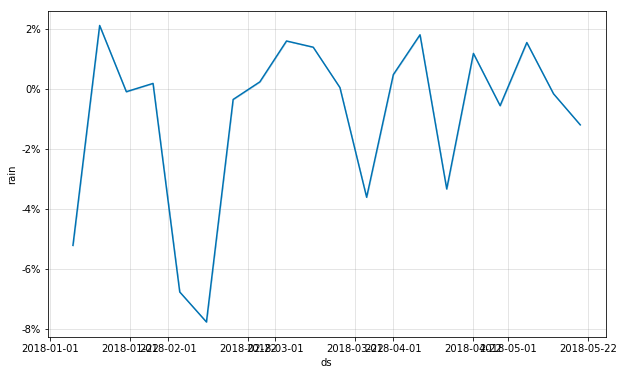

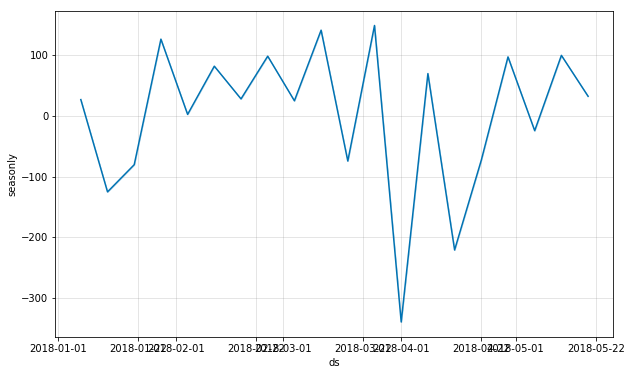

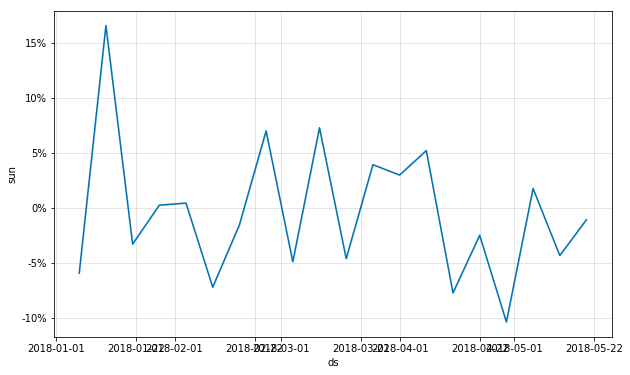

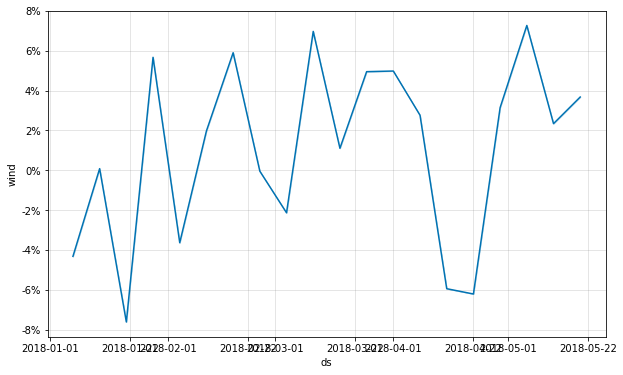

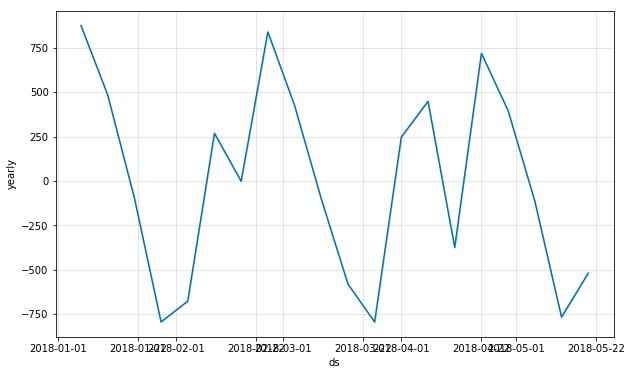

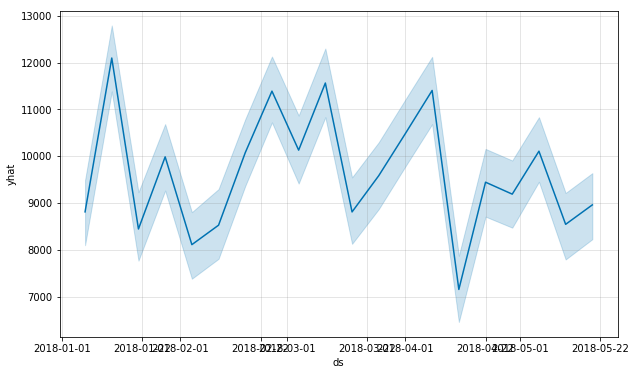

In [12]:
def prophet_func_112(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项、季节项以加法方式进入模型，相关变量以乘法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m112 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m112.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m112.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='additive')
    m112.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='additive')
    m112.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='additive')
    # 设置add_regressor中相关变量信息但不赋值
    m112.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m112.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m112.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m112.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m112.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='multiplicative')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m112.fit(df_train)
    future = m112.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future112 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future112
    forecast112 = m112.predict(future112)
    # 输出图形及数值预测结果
    fig1 = m112.plot(forecast112)
    fig2 = m112.plot_components(forecast112)
    for i in range(6, 67, 3):
        plot_forecast_component(m112, forecast112, forecast112.columns[i])

    prophet_amou = forecast112['yhat'].values
    trend_amou = forecast112['trend'].values
    holiday_amou = forecast112['holidays'].values
    seasonality_amou = forecast112['yearly'].values + forecast112['seasonly'].values + forecast112['monthly'].values
    relative_amou = forecast112['extra_regressors_multiplicative'].values
    
    if False not in (prophet_amou - (trend_amou * (1+relative_amou) + holiday_amou + seasonality_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_112()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([9045.859385103968,
  11725.93153521547,
  8276.74799057252,
  9550.269013345647,
  7910.4908730060615,
  8614.618308078436,
  10051.554770846642,
  11319.954464627956,
  10140.651818036073,
  11194.969724458559,
  8531.268994659335,
  9214.111118664998,
  10212.351259152983,
  11338.498432248216,
  7360.071869298443,
  9720.115471334562,
  9466.421951570957,
  9945.032590711702,
  8380.676142471199,
  8904.465047512756],
 array([8781.72246314, 8830.08765912, 8878.45285511, 8926.81805109,
        8975.18324707, 9023.54844305, 9071.91363903, 9120.27883501,
        9168.644031  , 9217.00922698, 9265.37442296, 9313.73961894,
        9362.10481492, 9410.4700109 , 9458.83520689, 9507.20040287,
        9555.56559885, 9603.93079483, 9652.29599081, 9700.66118679]),
 array([107.41081818,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0

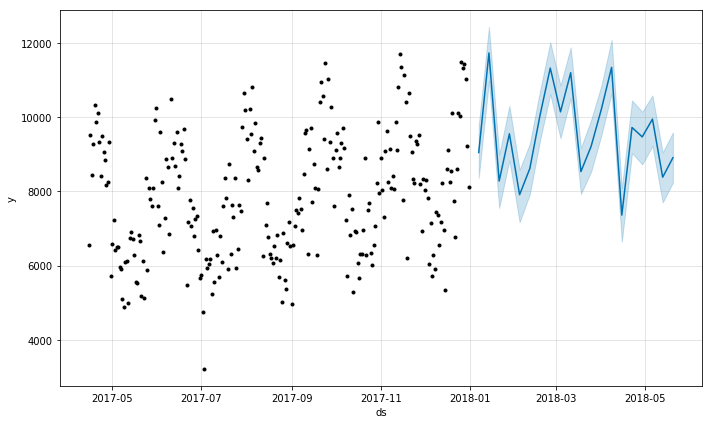

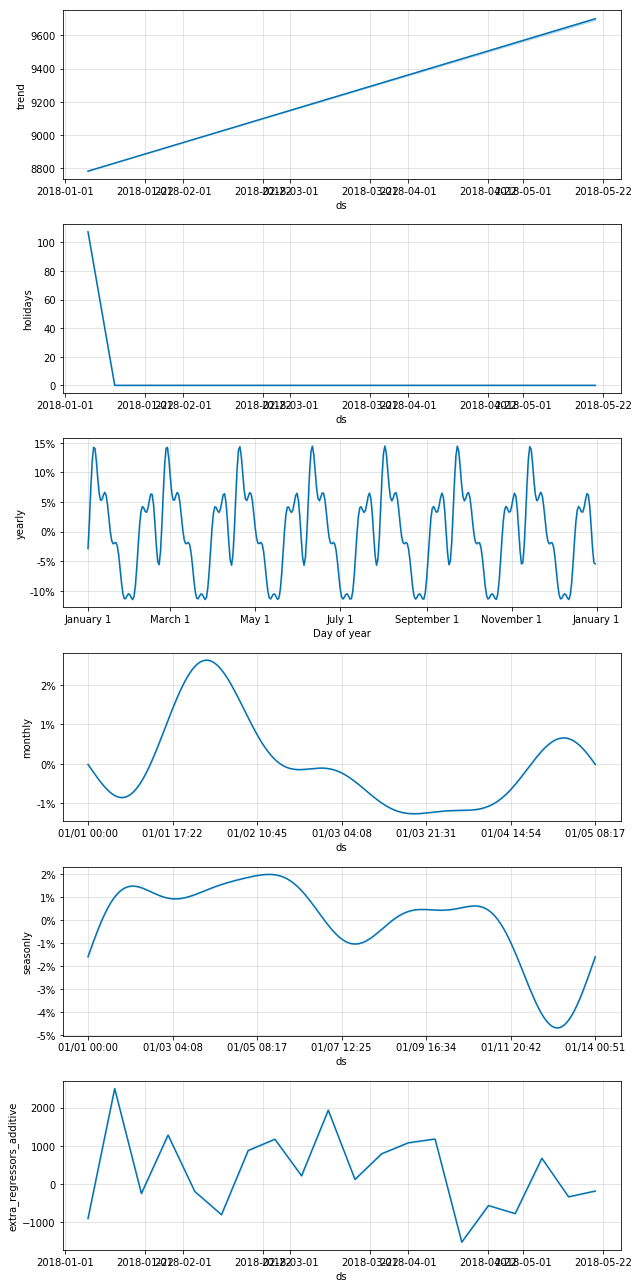

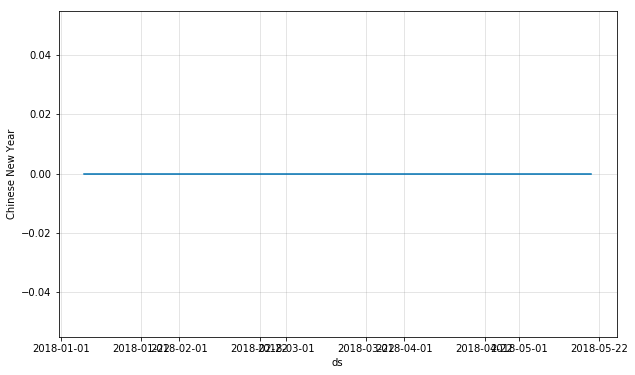

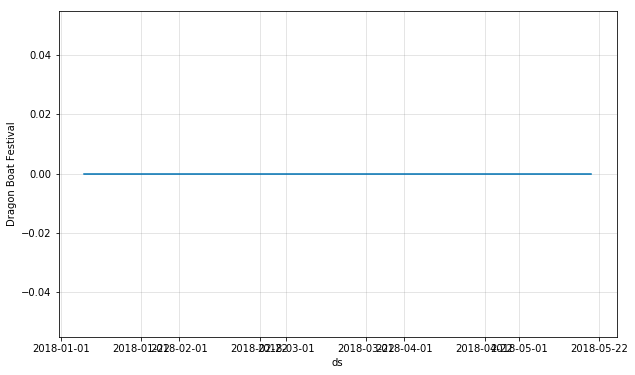

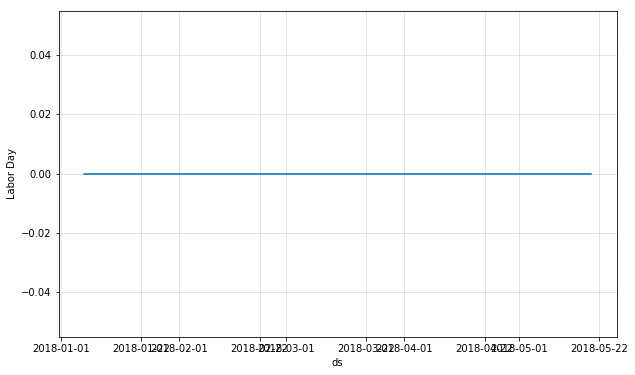

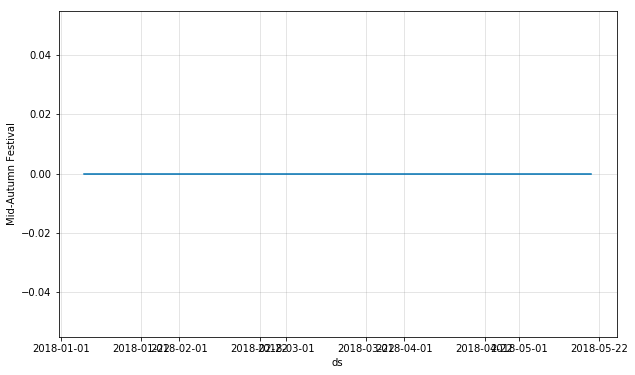

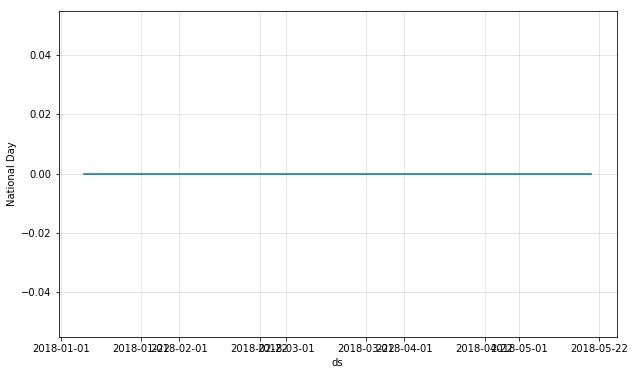

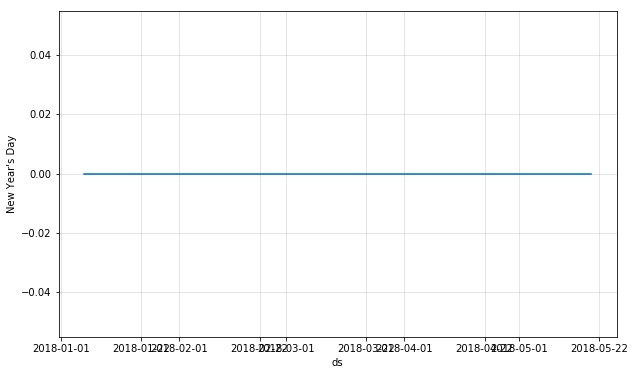

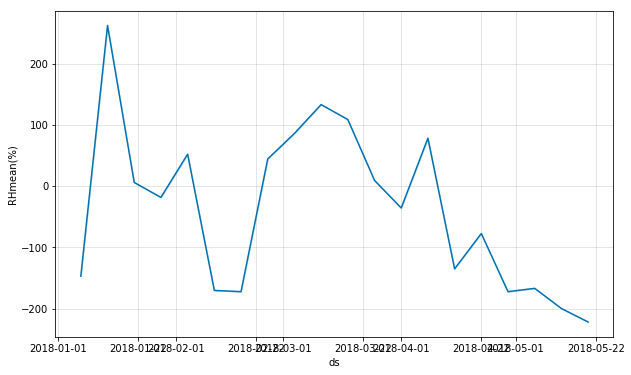

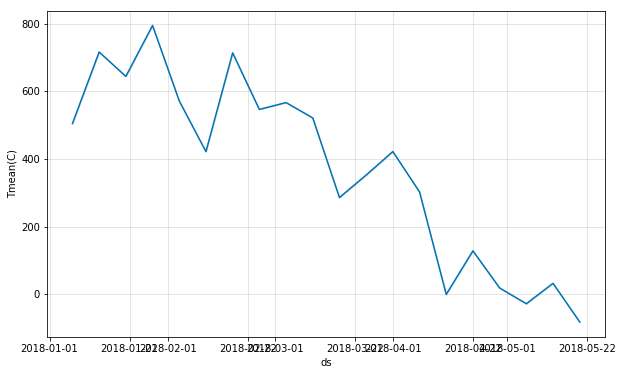

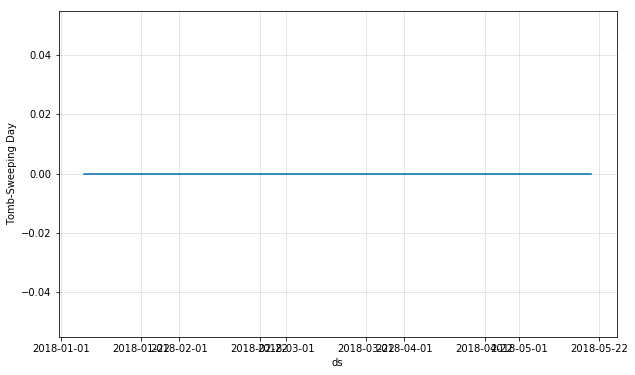

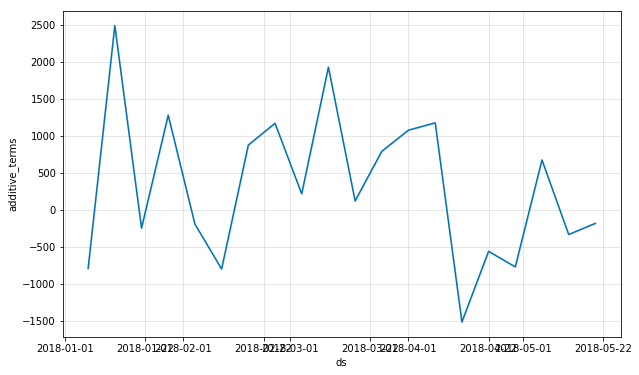

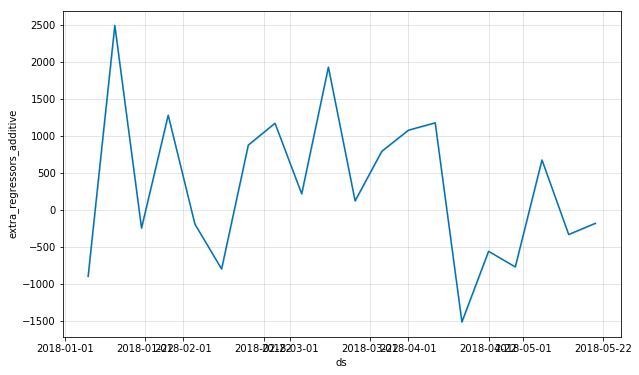

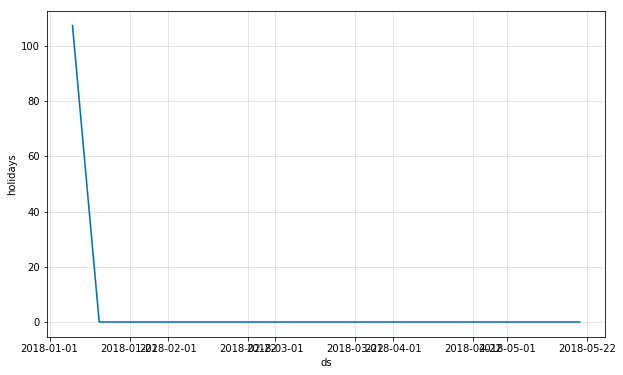

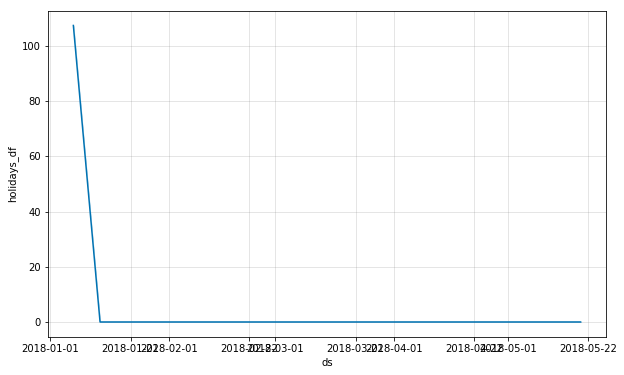

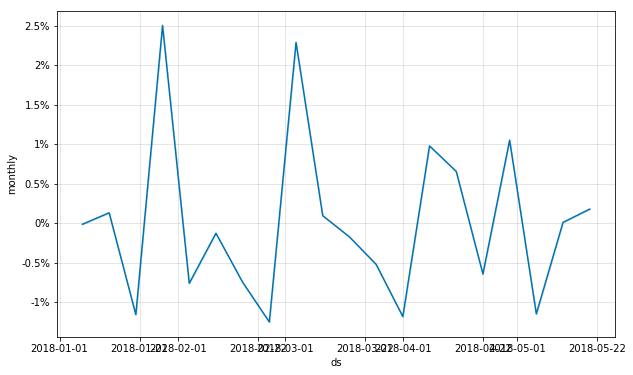

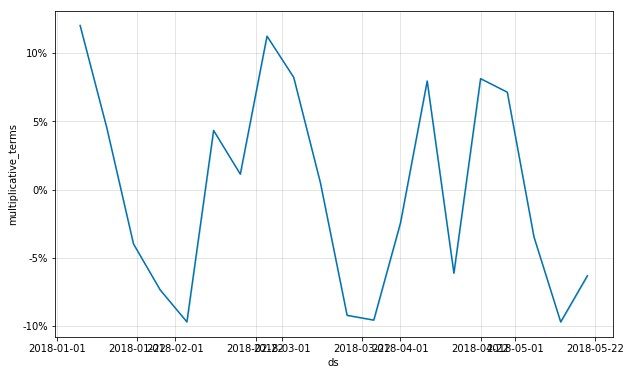

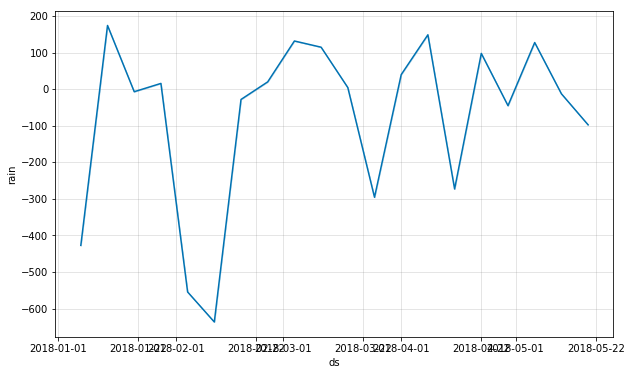

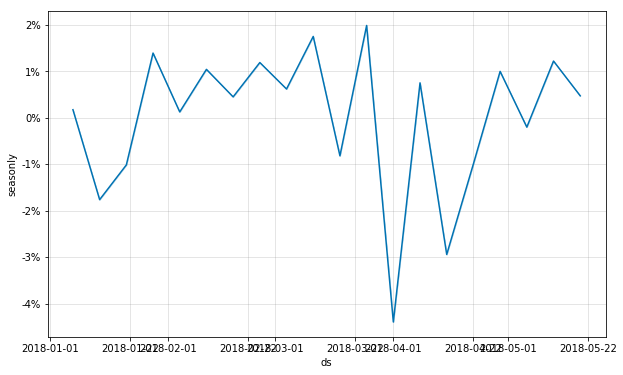

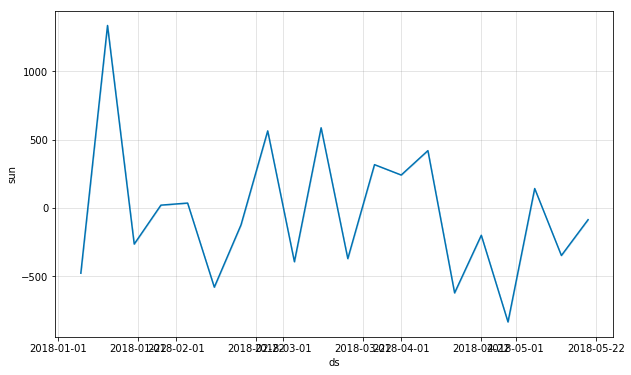

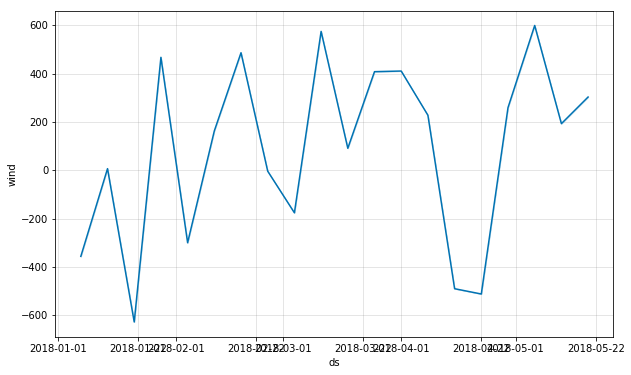

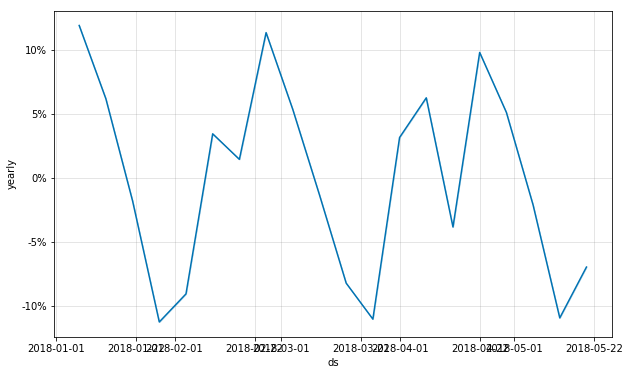

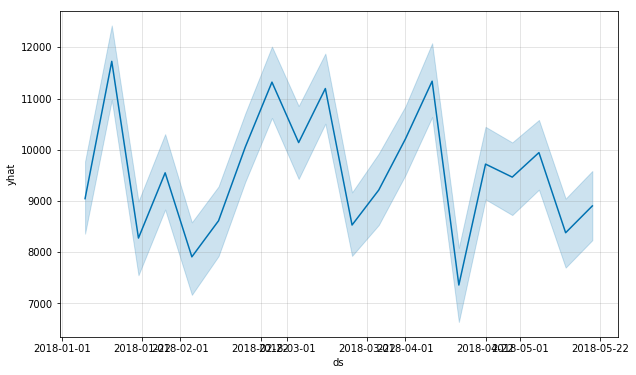

In [13]:
def prophet_func_121(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项、相关变量以加法方式进入模型，季节项以乘法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m121 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m121.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m121.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='multiplicative')
    m121.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='multiplicative')
    m121.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='multiplicative')
    # 设置add_regressor中相关变量信息但不赋值
    m121.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='additive')
    m121.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='additive')
    m121.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='additive')
    m121.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='additive')
    m121.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='additive')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m121.fit(df_train)
    future = m121.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future121 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future121
    forecast121 = m121.predict(future121)
    # 输出图形及数值预测结果
    fig1 = m121.plot(forecast121)
    fig2 = m121.plot_components(forecast121)
    for i in range(6, 67, 3):
        plot_forecast_component(m121, forecast121, forecast121.columns[i])

    prophet_amou = forecast121['yhat'].values
    trend_amou = forecast121['trend'].values
    holiday_amou = forecast121['holidays'].values
    seasonality_amou = forecast121['yearly'].values + forecast121['seasonly'].values + forecast121['monthly'].values
    relative_amou = forecast121['extra_regressors_additive'].values
    
    if False not in (prophet_amou - (trend_amou * (1+seasonality_amou) + holiday_amou + relative_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_121()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8958.101971938497,
  11975.683762802202,
  8143.82994986525,
  9532.09178269434,
  7709.48941686974,
  8396.799015862653,
  10001.022615571099,
  11487.152281900793,
  10224.687740924988,
  11404.993362222749,
  8449.083298329677,
  9166.758864487216,
  10250.586494651934,
  11410.99248728313,
  7145.731815618357,
  9735.936040881488,
  9371.406744912032,
  9950.751944215242,
  8177.843870996515,
  8731.429872900771],
 array([8774.88245512, 8822.21927758, 8869.55610004, 8916.8929225 ,
        8964.22974497, 9011.56656743, 9058.90338989, 9106.24021235,
        9153.57703482, 9200.91385728, 9248.25067974, 9295.5875022 ,
        9342.92432467, 9390.26114713, 9437.59796959, 9484.93479205,
        9532.27161452, 9579.60843698, 9626.94525944, 9674.2820819 ]),
 array([92.15926214,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.    

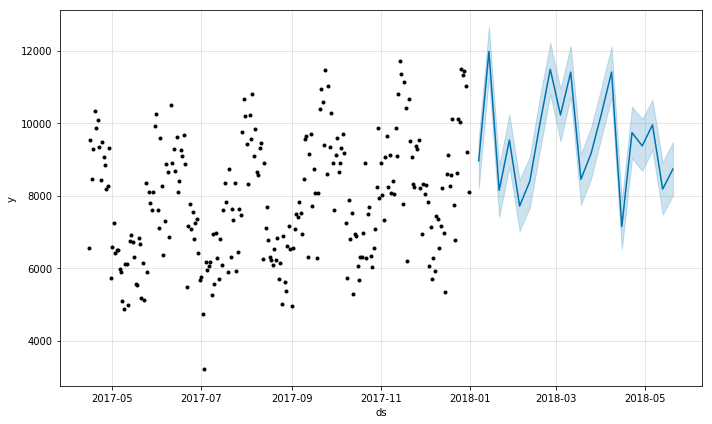

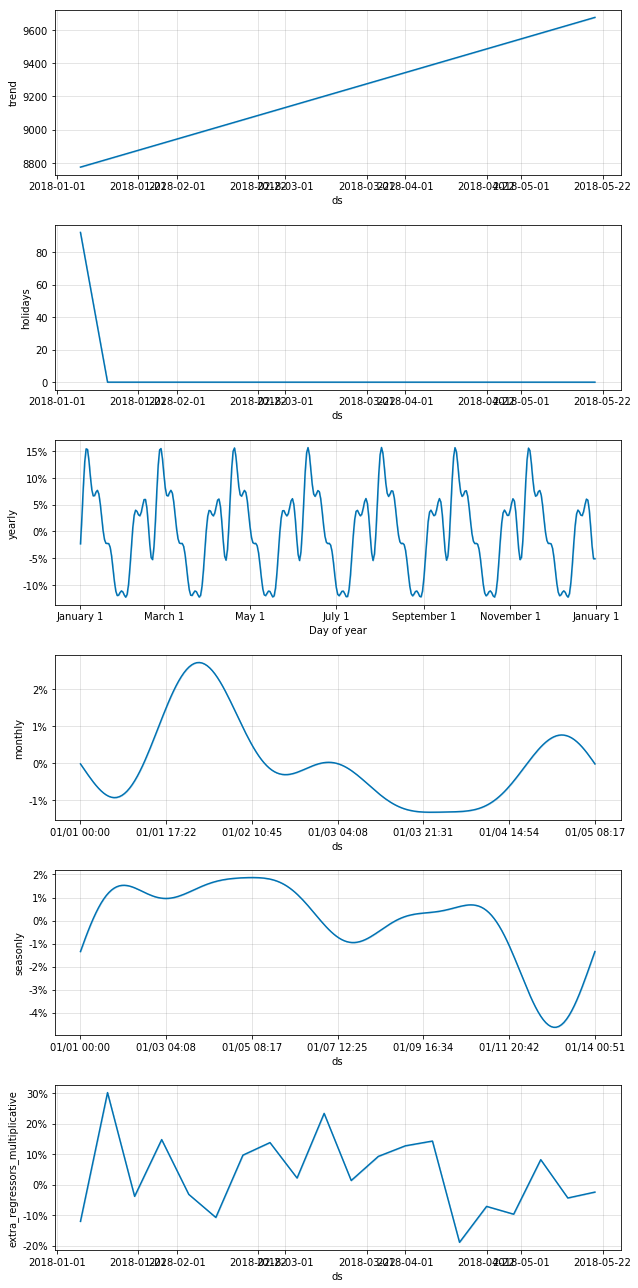

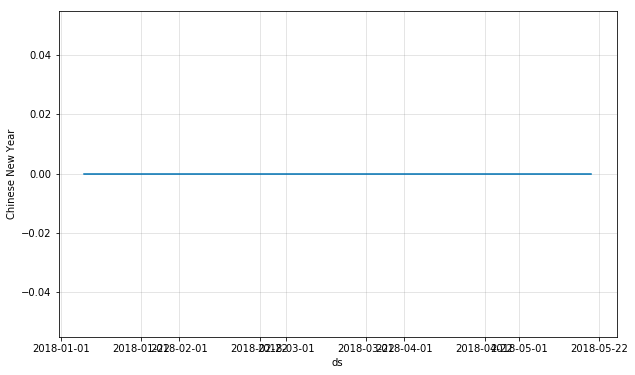

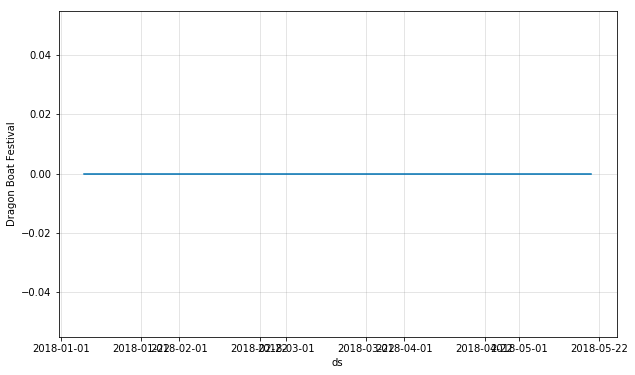

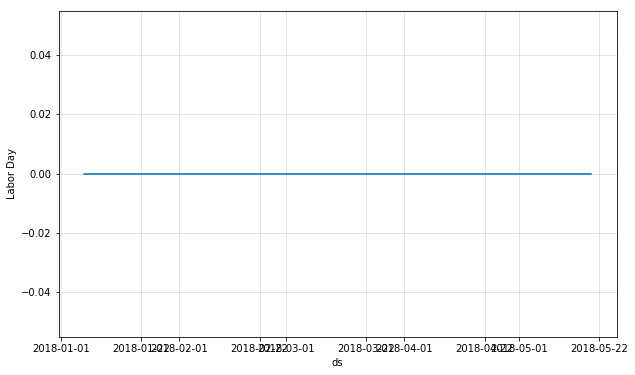

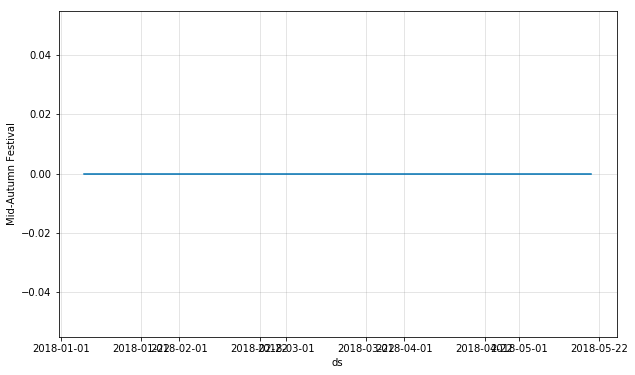

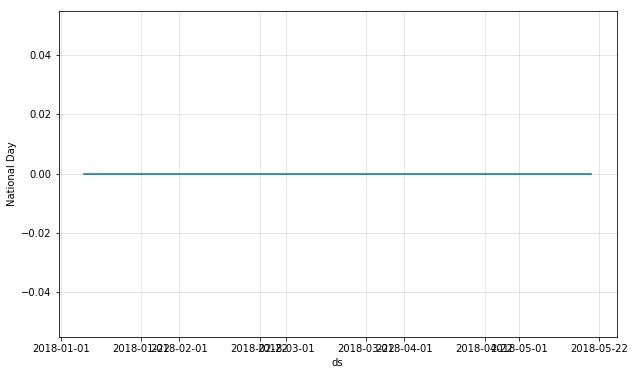

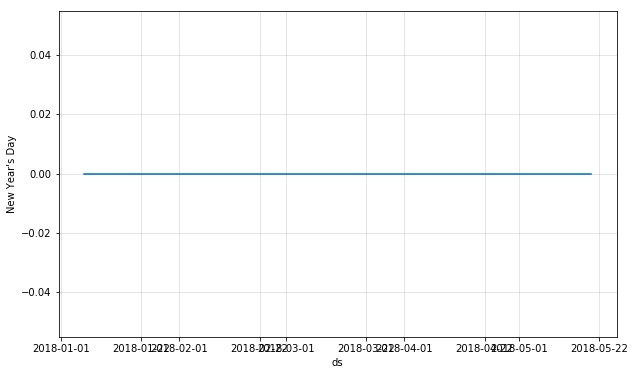

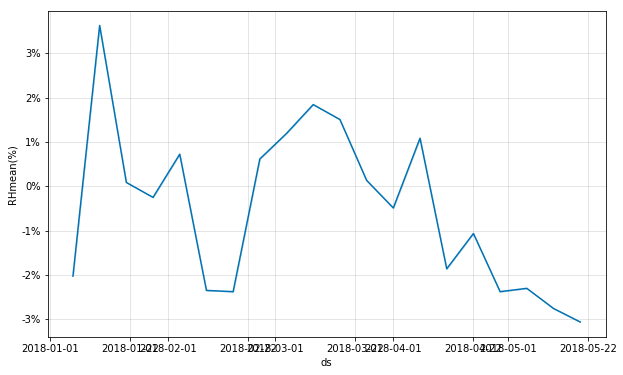

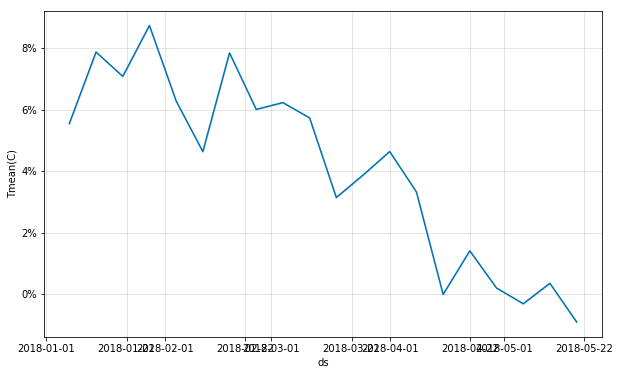

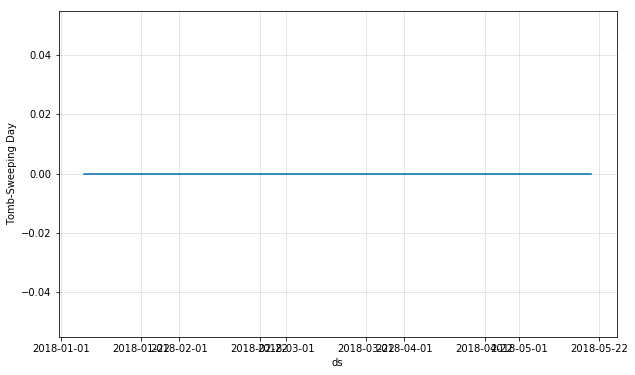

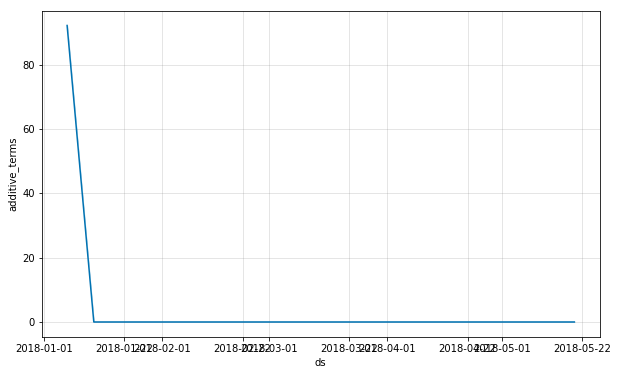

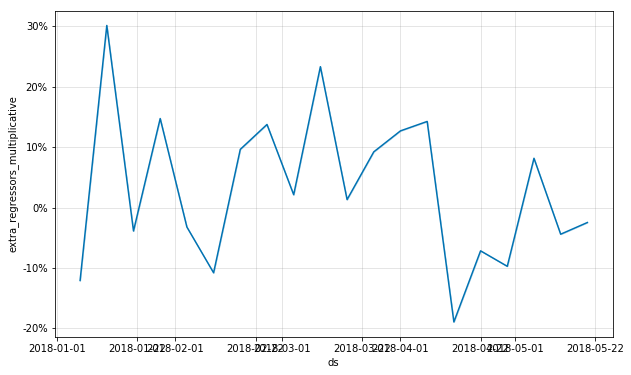

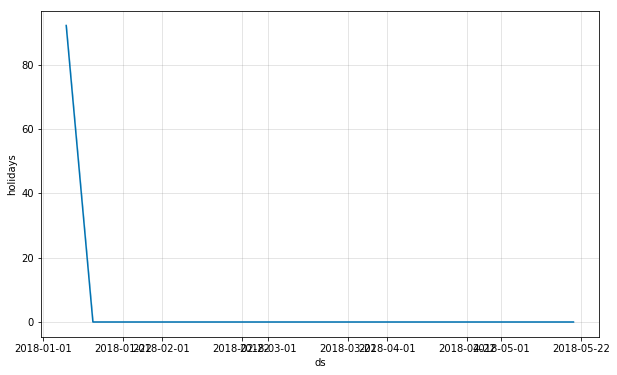

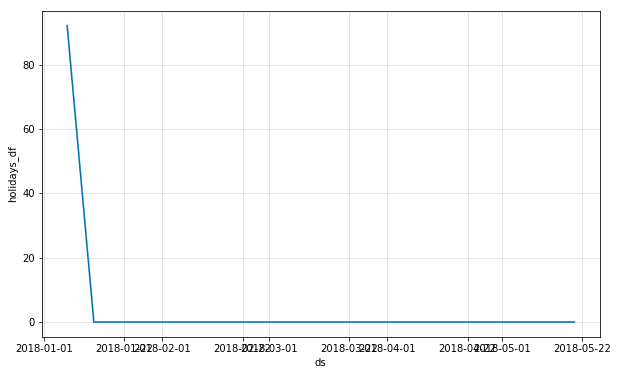

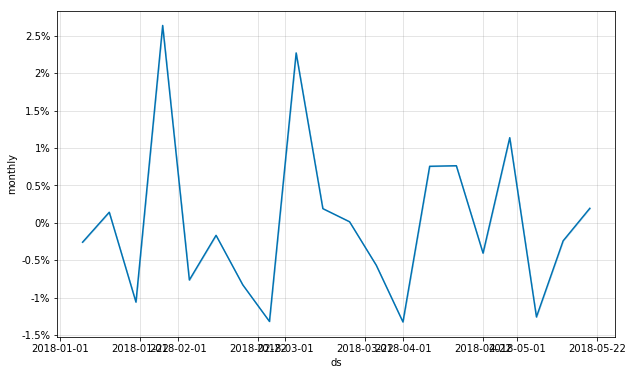

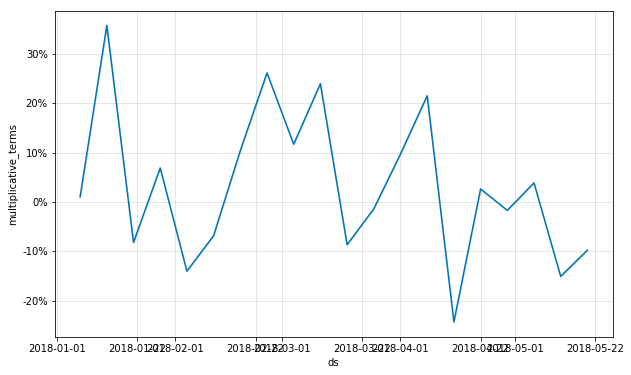

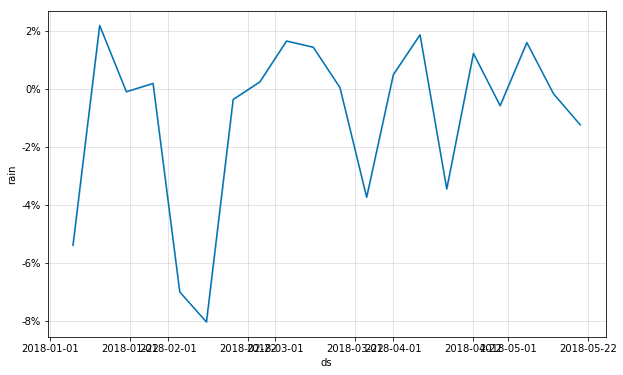

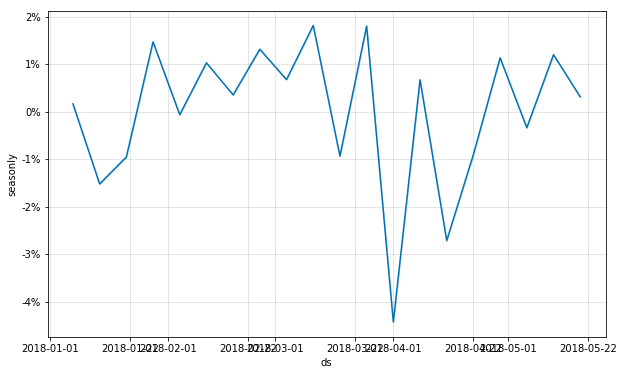

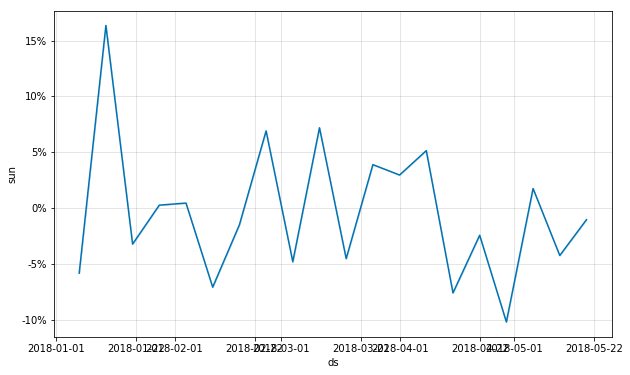

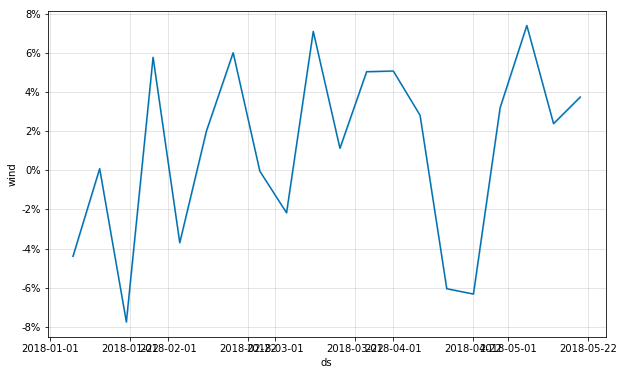

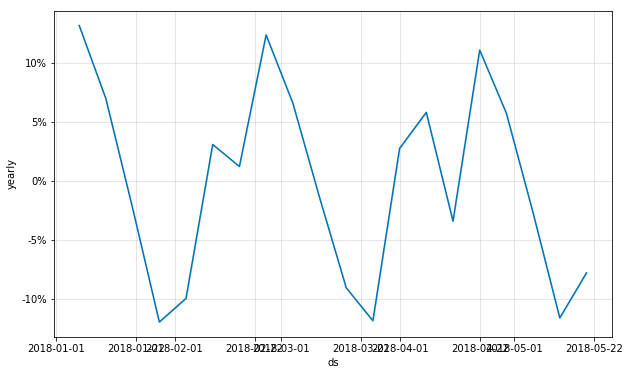

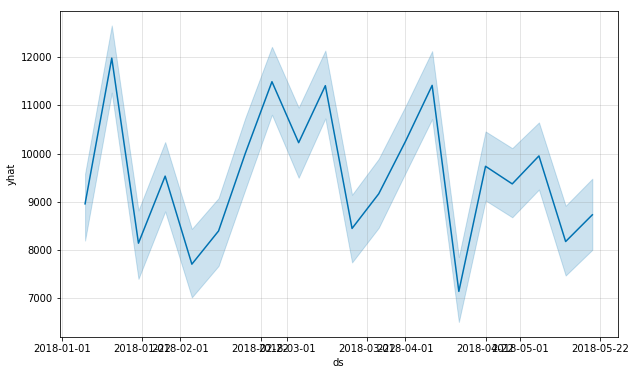

In [14]:
def prophet_func_122(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项以加法方式进入模型，季节项、相关变量以乘法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m122 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='additive', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m122.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m122.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='multiplicative')
    m122.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='multiplicative')
    m122.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='multiplicative')
    # 设置add_regressor中相关变量信息但不赋值
    m122.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m122.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m122.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m122.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m122.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='multiplicative')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m122.fit(df_train)
    future = m122.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future122 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future122
    forecast122 = m122.predict(future122)
    # 输出图形及数值预测结果
    fig1 = m122.plot(forecast122)
    fig2 = m122.plot_components(forecast122)
    for i in range(6, 67, 3):
        plot_forecast_component(m122, forecast122, forecast122.columns[i])

    prophet_amou = forecast122['yhat'].values
    trend_amou = forecast122['trend'].values
    holiday_amou = forecast122['holidays'].values
    seasonality_amou = forecast122['yearly'].values + forecast122['seasonly'].values + forecast122['monthly'].values
    relative_amou = forecast122['extra_regressors_multiplicative'].values
    
    if False not in (prophet_amou - (trend_amou * (1+seasonality_amou+relative_amou) + holiday_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_122()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8877.994365533179,
  11663.832783789812,
  8291.267354742042,
  9632.07075118645,
  7995.437599360704,
  8602.792887969228,
  10060.185986921268,
  11230.397976137843,
  10039.252645787617,
  11172.80925477845,
  8632.02462919705,
  9357.06137239418,
  10248.717020524893,
  11316.393009978425,
  7540.061436396656,
  9591.817870262319,
  9400.737148608348,
  10017.585600861981,
  8601.721007356258,
  9076.837591846152],
 array([8806.55117701, 8855.56819089, 8904.58520477, 8953.60221865,
        9002.61923254, 9051.63624642, 9100.6532603 , 9149.67027418,
        9198.68728806, 9247.70430194, 9296.72131583, 9345.73832971,
        9394.75534359, 9443.77235747, 9492.78937135, 9541.80638524,
        9590.82339912, 9639.840413  , 9688.85742688, 9737.87444076]),
 array([0.00155002, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.       

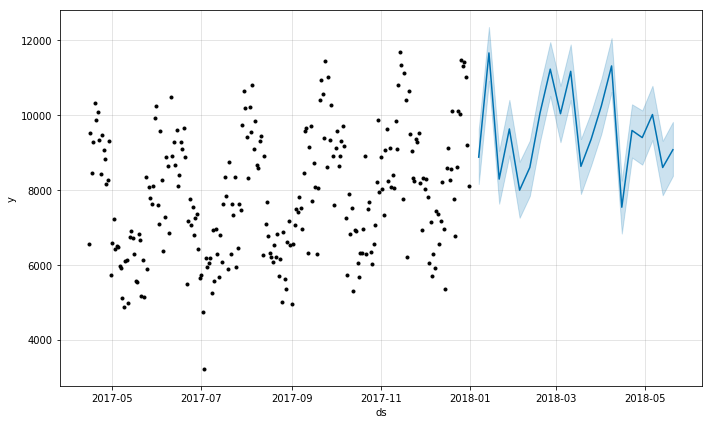

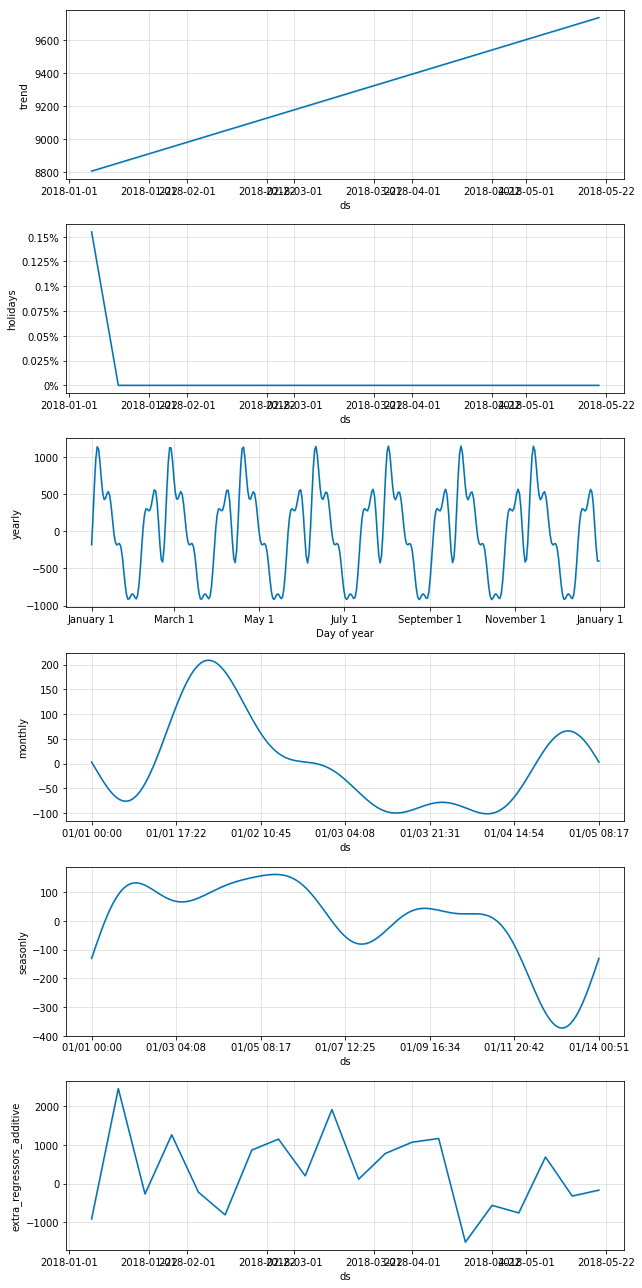

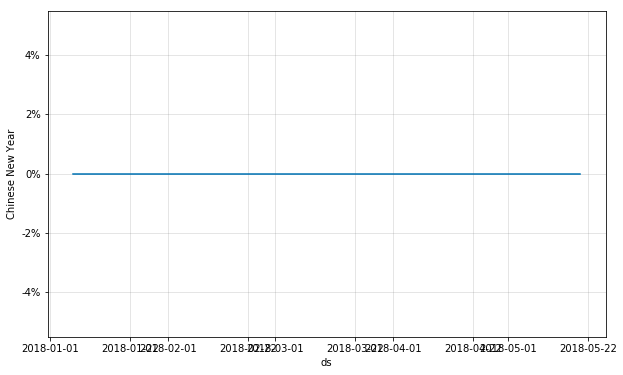

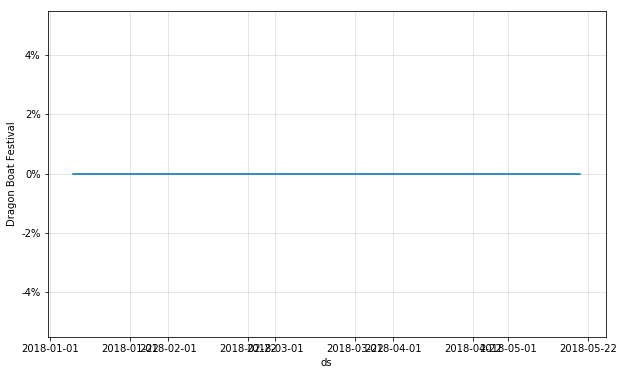

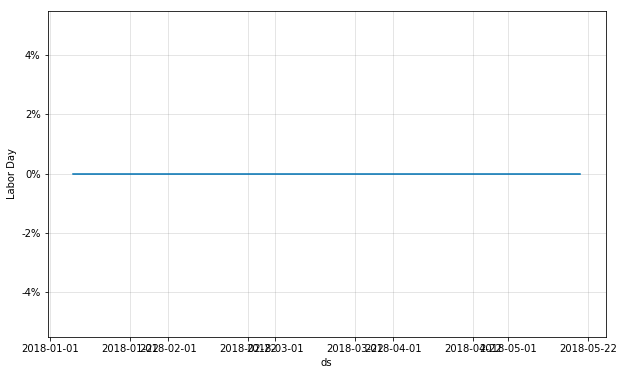

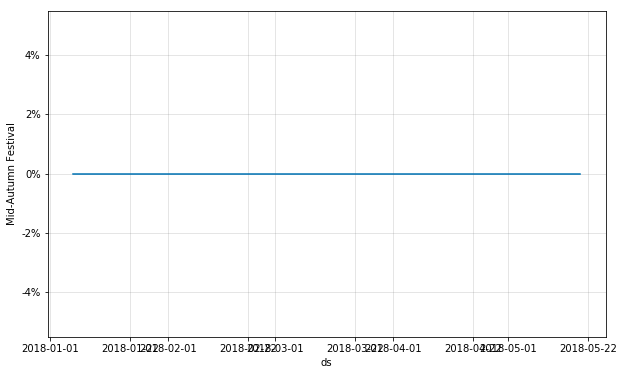

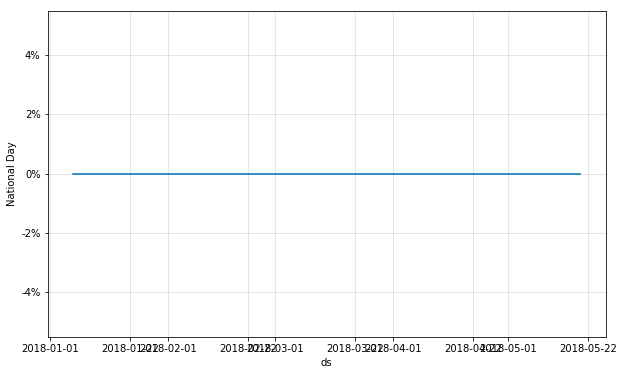

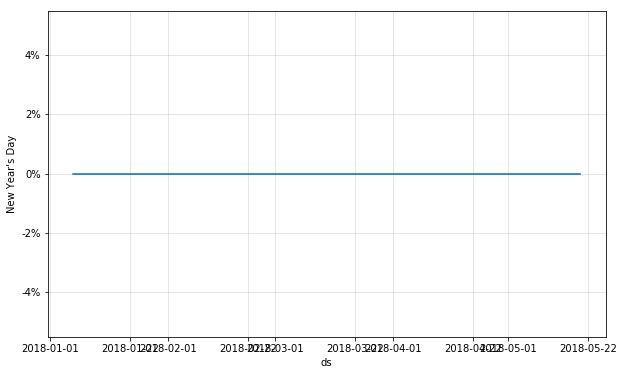

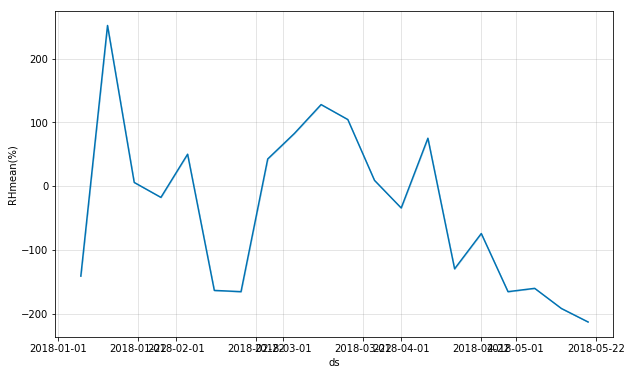

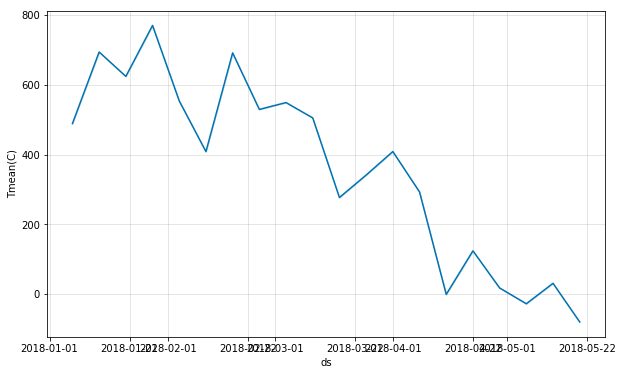

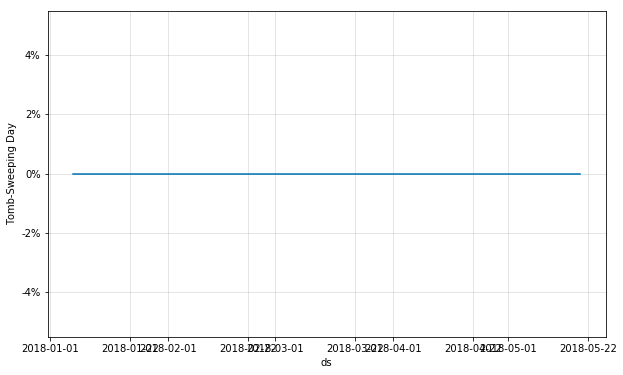

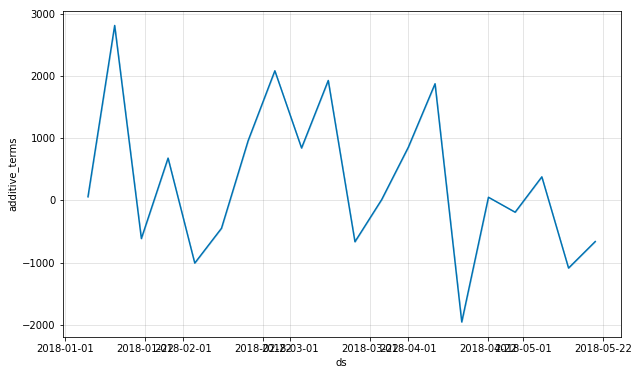

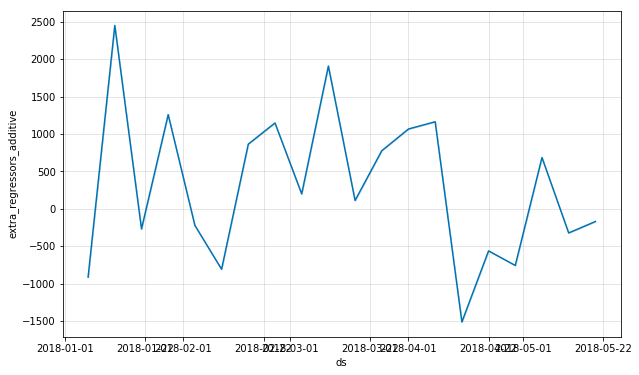

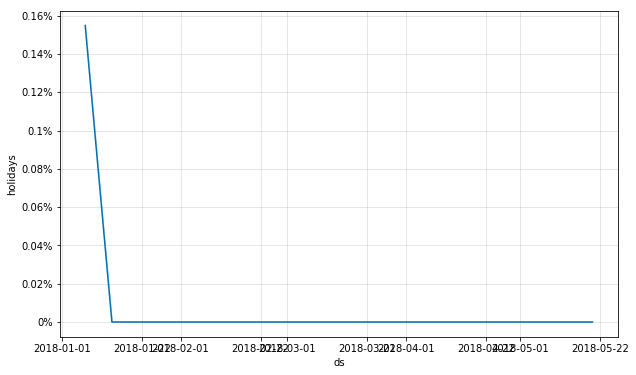

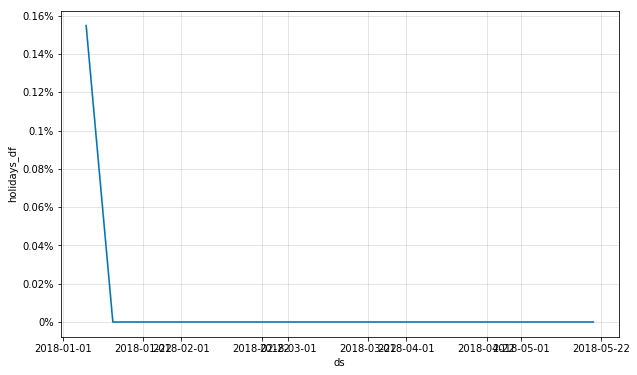

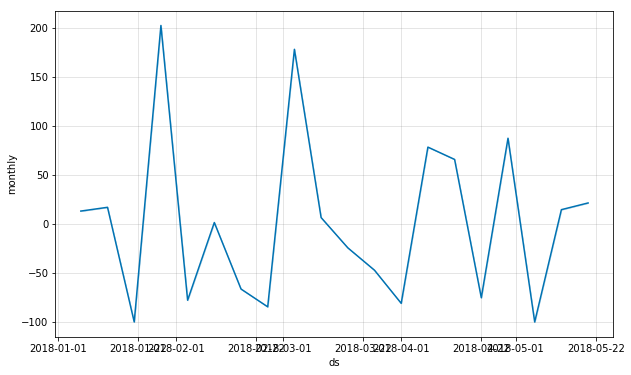

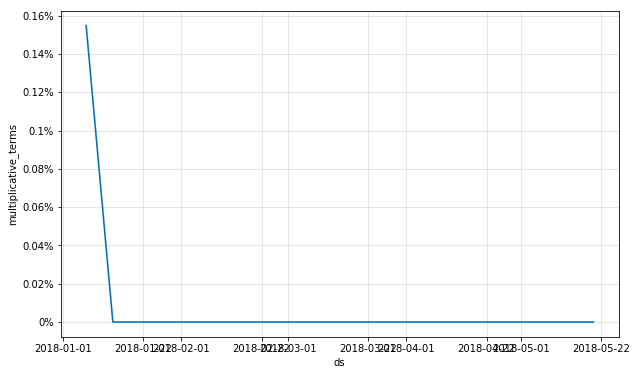

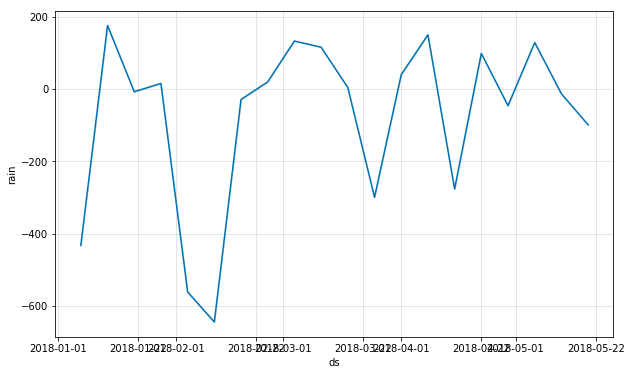

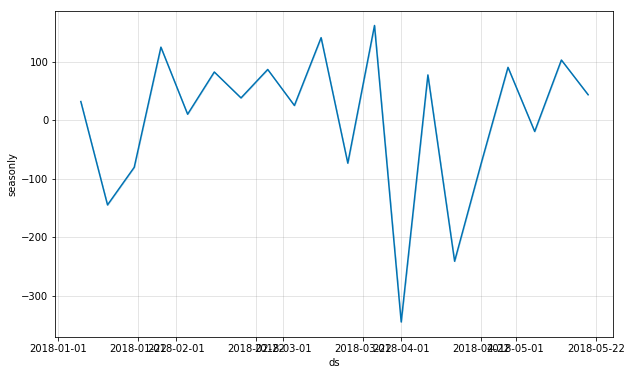

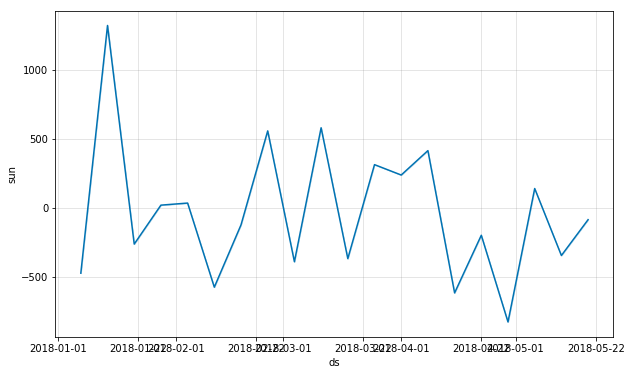

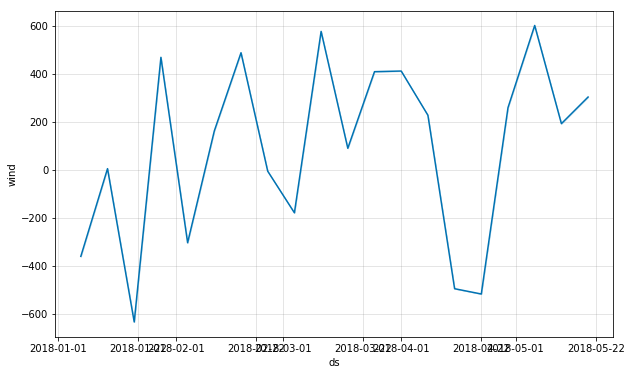

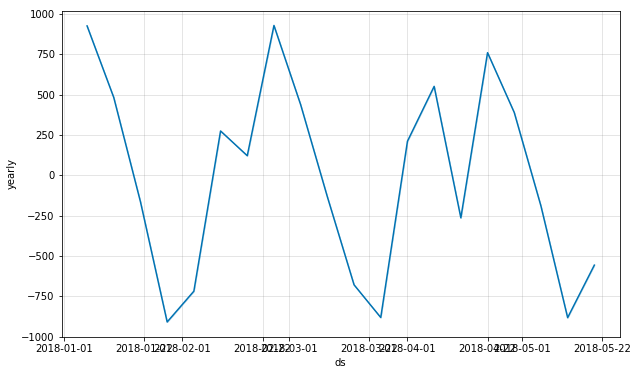

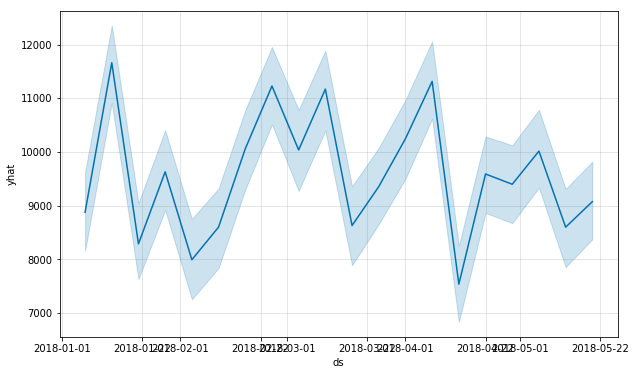

In [15]:
def prophet_func_211(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项以乘法方式进入模型，季节项、相关变量以加法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m211 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m211.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m211.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='additive')
    m211.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='additive')
    m211.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='additive')
    # 设置add_regressor中相关变量信息但不赋值
    m211.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='additive')
    m211.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='additive')
    m211.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='additive')
    m211.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='additive')
    m211.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='additive')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m211.fit(df_train)
    future = m211.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future211 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future211
    forecast211 = m211.predict(future211)
    # 输出图形及数值预测结果
    fig1 = m211.plot(forecast211)
    fig2 = m211.plot_components(forecast211)
    for i in range(6, 67, 3):
        plot_forecast_component(m211, forecast211, forecast211.columns[i])

    prophet_amou = forecast211['yhat'].values
    trend_amou = forecast211['trend'].values
    holiday_amou = forecast211['holidays'].values
    seasonality_amou = forecast211['yearly'].values + forecast211['seasonly'].values + forecast211['monthly'].values
    relative_amou = forecast211['extra_regressors_additive'].values
    
    if False not in (prophet_amou - (trend_amou * (1+holiday_amou) + seasonality_amou + relative_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_211()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8805.95226488682,
  12032.318388263657,
  8335.617856542422,
  9906.083330729898,
  8024.9078202437,
  8501.619119053481,
  10151.66491393008,
  11429.825850355419,
  10138.750611719304,
  11504.58088508659,
  8706.298594537608,
  9530.65314139473,
  10477.110383313604,
  11506.180797058136,
  7231.119213639803,
  9504.919039983353,
  9230.249629100674,
  10141.347161870503,
  8544.074123500292,
  9028.242249961784],
 array([8801.13165504, 8850.01812667, 8898.90459829, 8947.79106991,
        8996.67754153, 9045.56401315, 9094.45048478, 9143.3369564 ,
        9192.22342802, 9241.10989964, 9289.99637126, 9338.88284289,
        9387.76931451, 9436.65578613, 9485.54225775, 9534.42872937,
        9583.31520099, 9632.20167262, 9681.08814424, 9729.97461586]),
 array([0.00159562, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ,

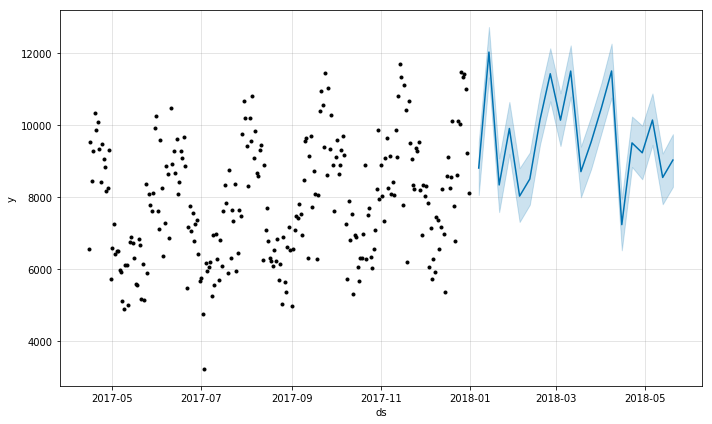

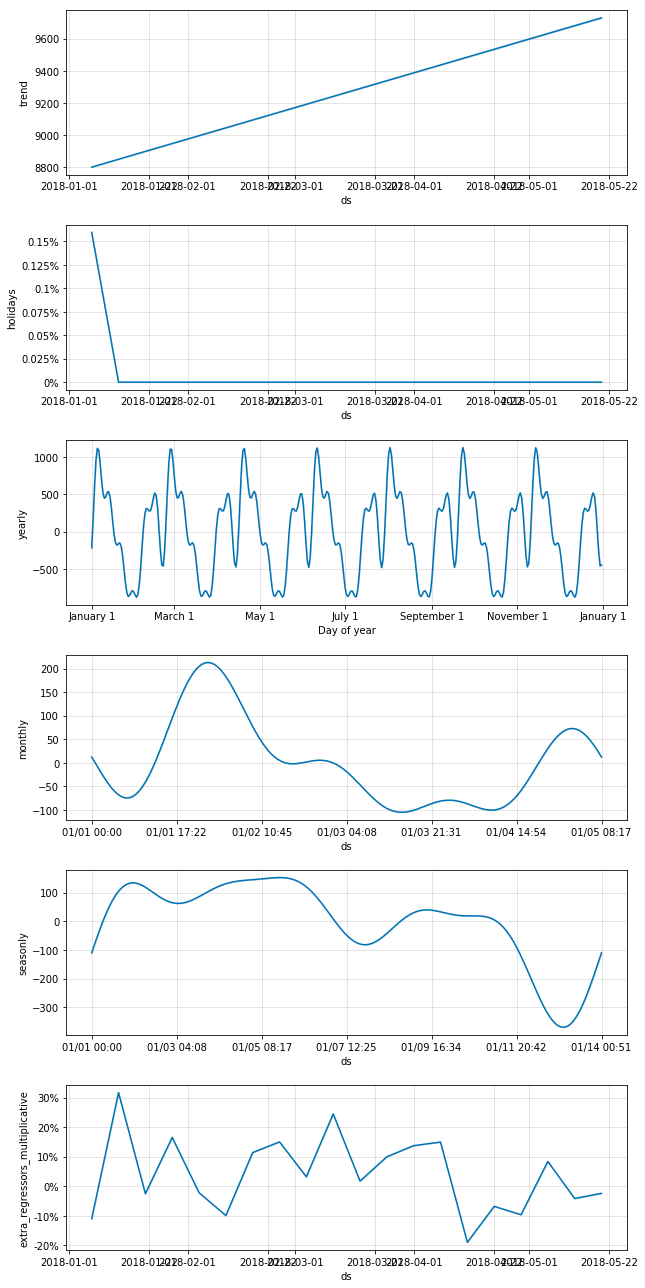

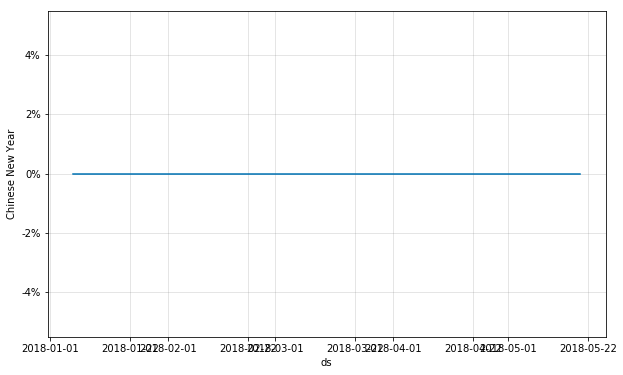

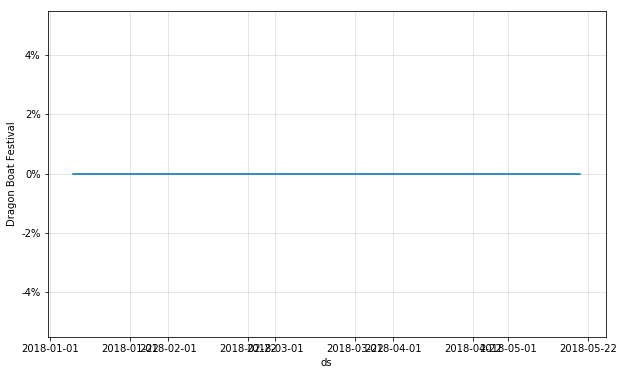

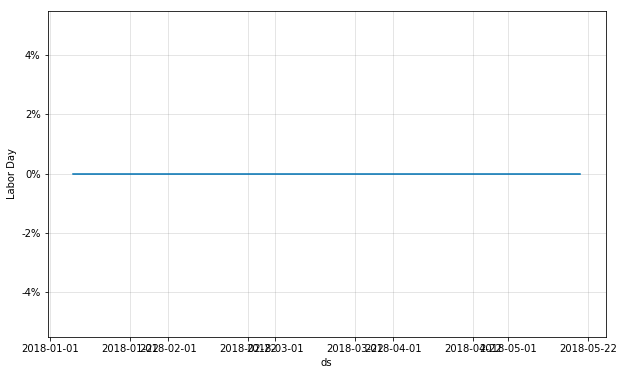

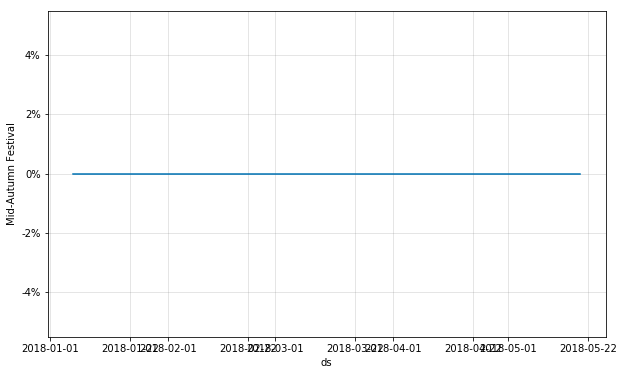

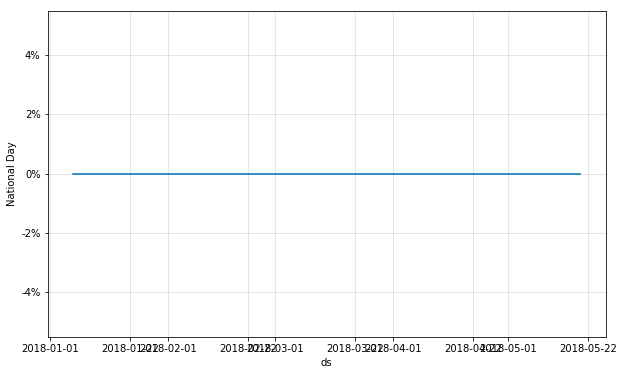

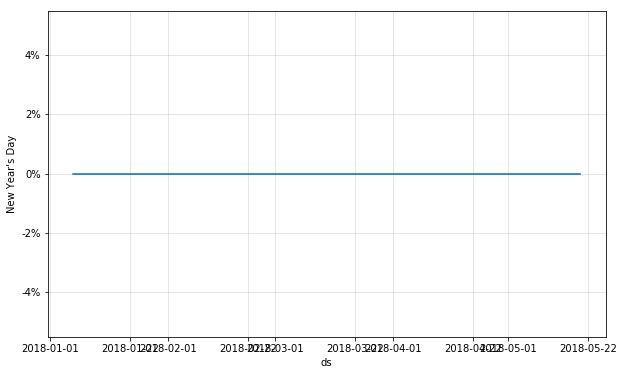

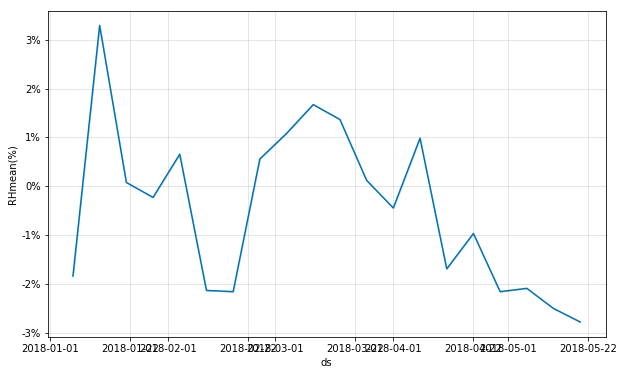

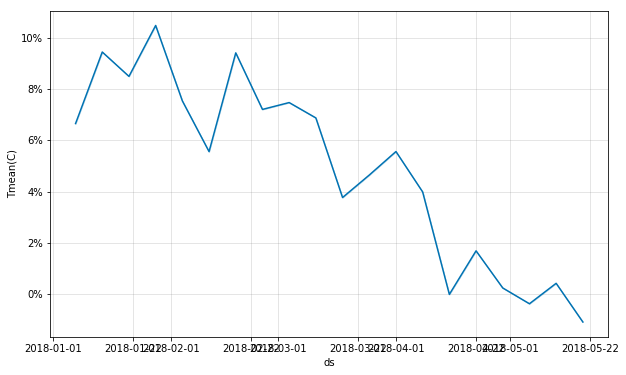

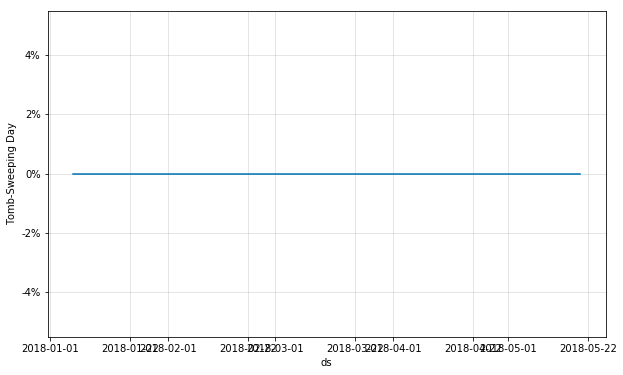

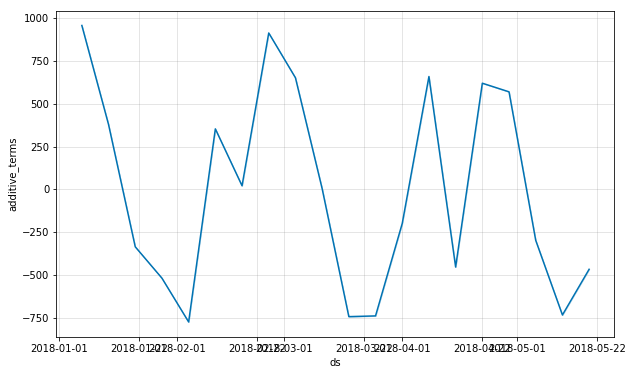

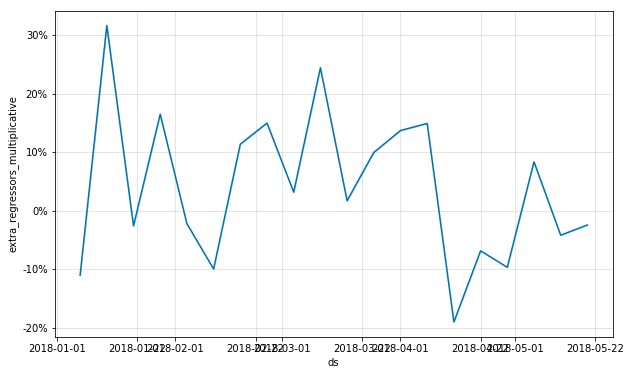

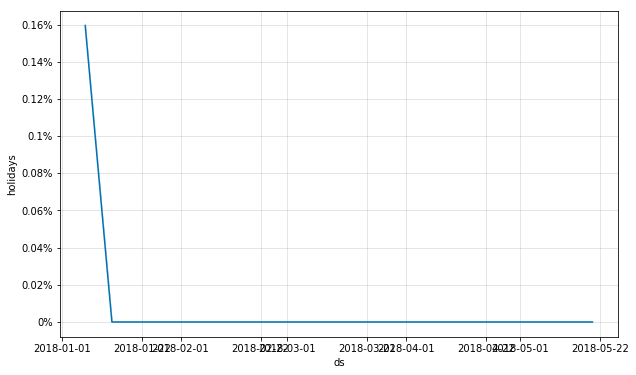

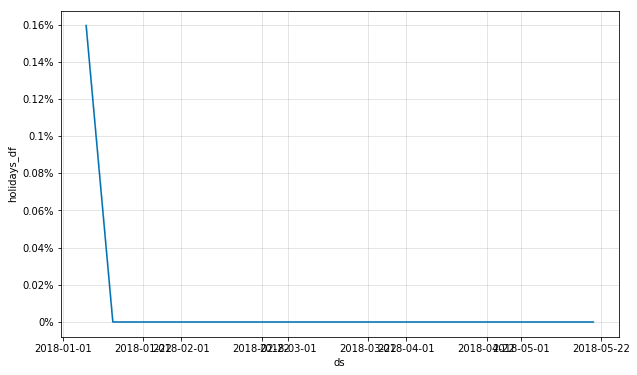

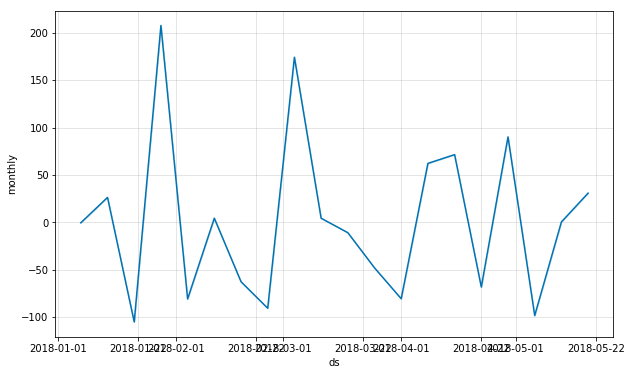

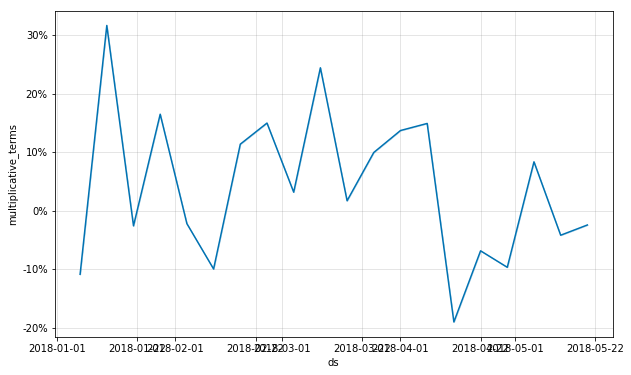

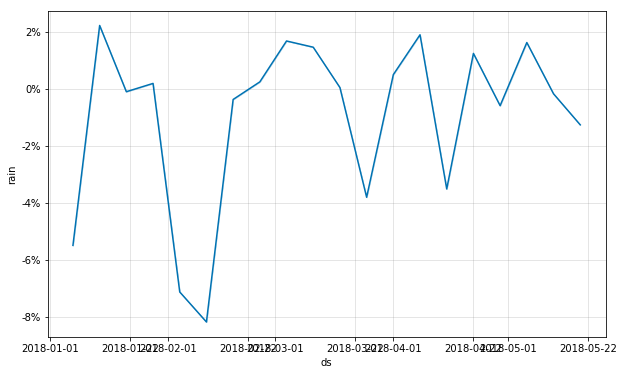

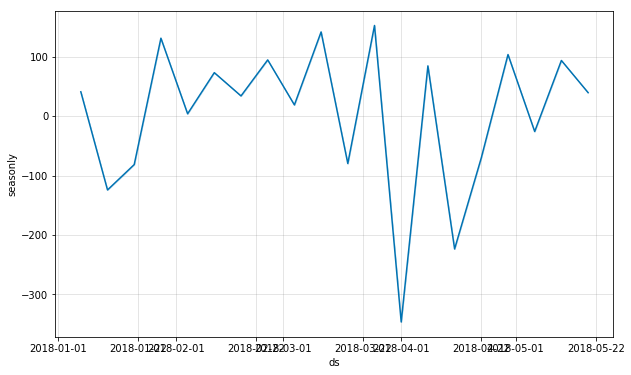

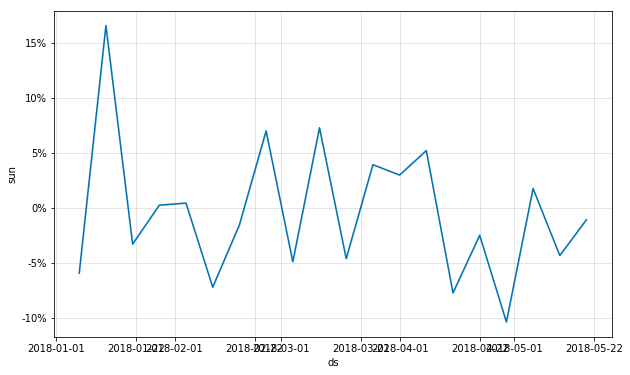

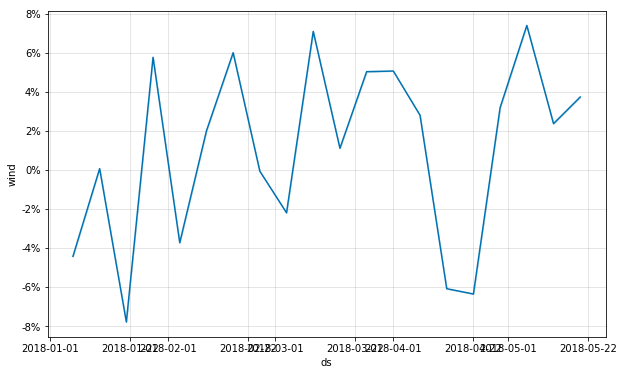

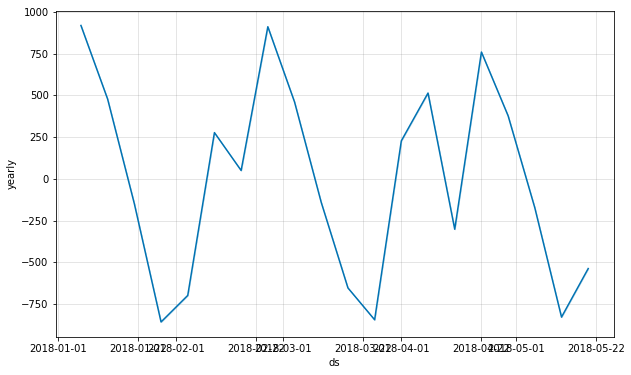

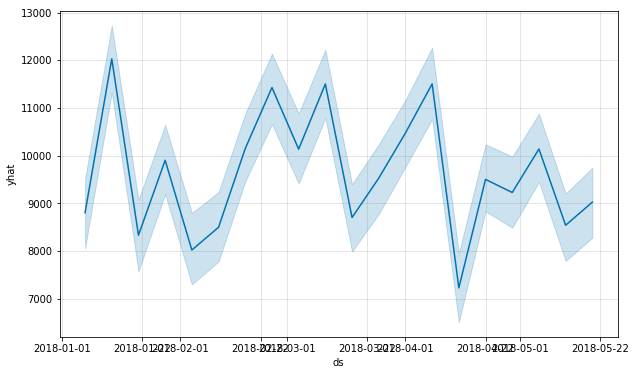

In [16]:
def prophet_func_212(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项、相关变量以乘法方式进入模型，季节项以加法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m212 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m212.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m212.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='additive')
    m212.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='additive')
    m212.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='additive')
    # 设置add_regressor中相关变量信息但不赋值
    m212.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m212.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m212.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m212.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='multiplicative')
    m212.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='multiplicative')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m212.fit(df_train)
    future = m212.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future212 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future212
    forecast212 = m212.predict(future212)
    # 输出图形及数值预测结果
    fig1 = m212.plot(forecast212)
    fig2 = m212.plot_components(forecast212)
    for i in range(6, 67, 3):
        plot_forecast_component(m212, forecast212, forecast212.columns[i])

    prophet_amou = forecast212['yhat'].values
    trend_amou = forecast212['trend'].values
    holiday_amou = forecast212['holidays'].values
    seasonality_amou = forecast212['yearly'].values + forecast212['seasonly'].values + forecast212['monthly'].values
    relative_amou = forecast212['extra_regressors_multiplicative'].values
    
    if False not in (prophet_amou - (trend_amou * (1+holiday_amou+relative_amou) + seasonality_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_212()
predict_result


/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


([8985.700551285458,
  11769.948799463926,
  8352.580373497067,
  9682.06935184761,
  8003.836769581363,
  8650.690563228993,
  10102.324251916858,
  11301.935794704075,
  10148.79699402072,
  11228.50866608485,
  8595.726571942538,
  9318.584635037723,
  10255.233889326279,
  11411.236459953943,
  7335.349986824735,
  9663.302227523647,
  9436.86513693892,
  9973.461862271024,
  8446.313261041922,
  8945.463490488299],
 array([8786.06090666, 8834.52952088, 8882.9981351 , 8931.46674932,
        8979.93536354, 9028.40397776, 9076.87259198, 9125.3412062 ,
        9173.80982041, 9222.27843463, 9270.74704885, 9319.21566307,
        9367.68427729, 9416.15289151, 9464.62150573, 9513.09011995,
        9561.55873417, 9610.02734838, 9658.4959626 , 9706.96457682]),
 array([0.0061312, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.  

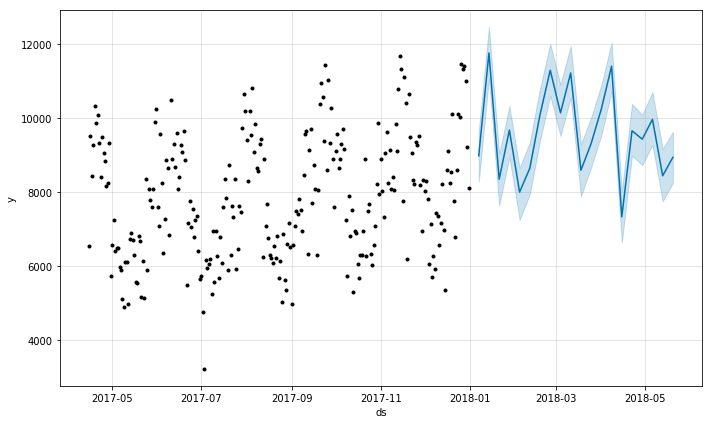

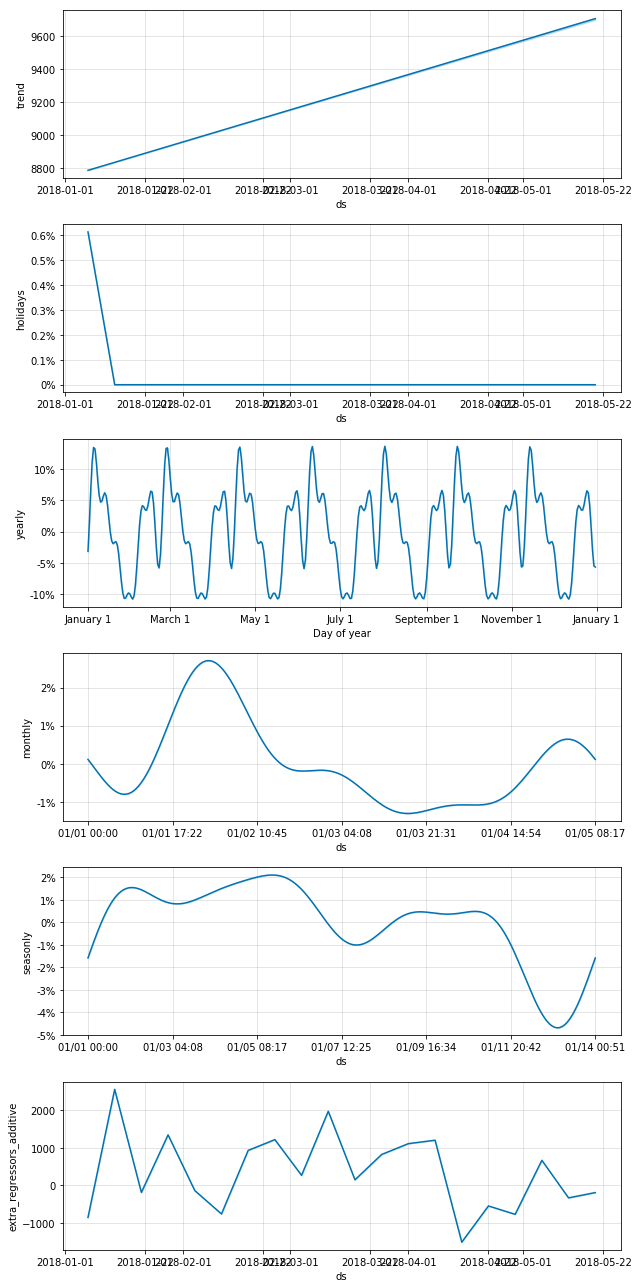

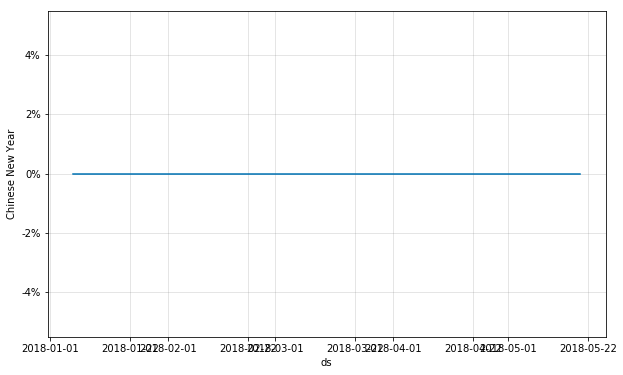

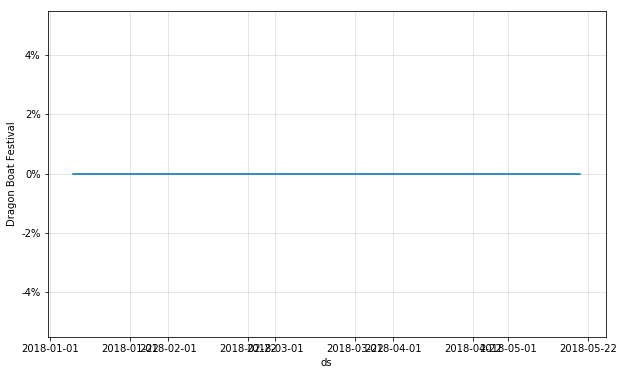

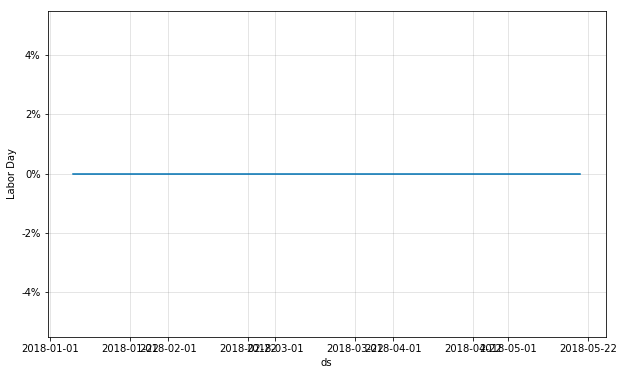

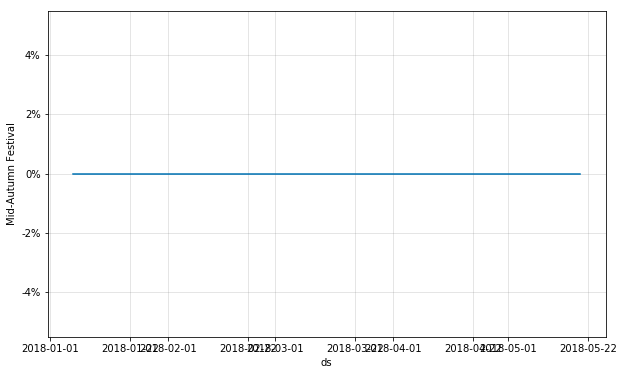

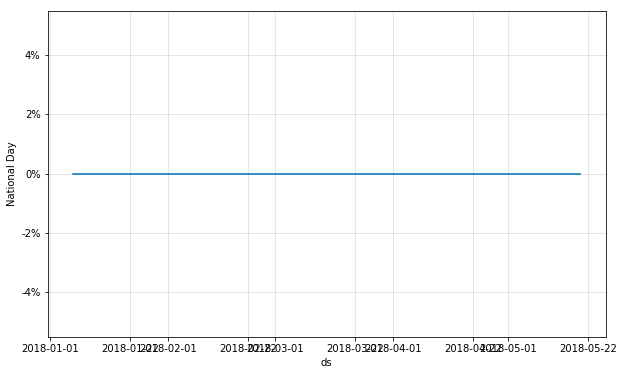

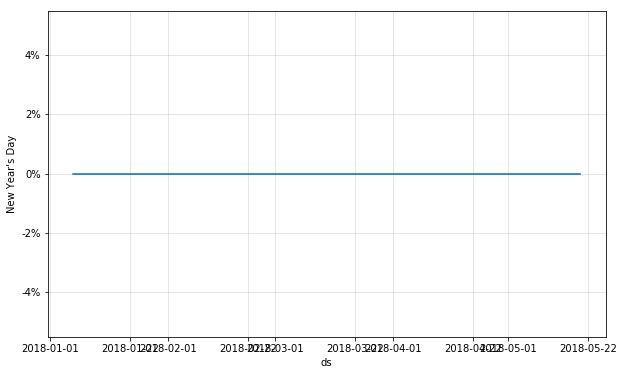

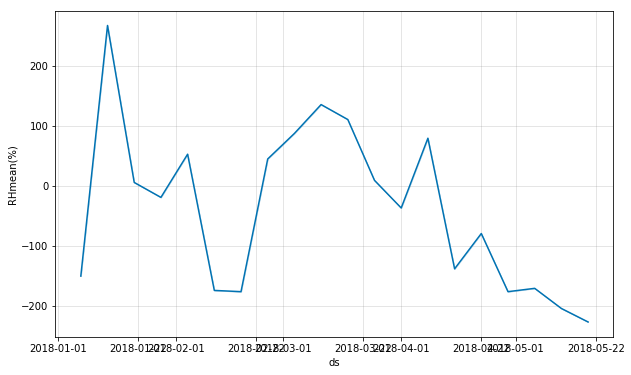

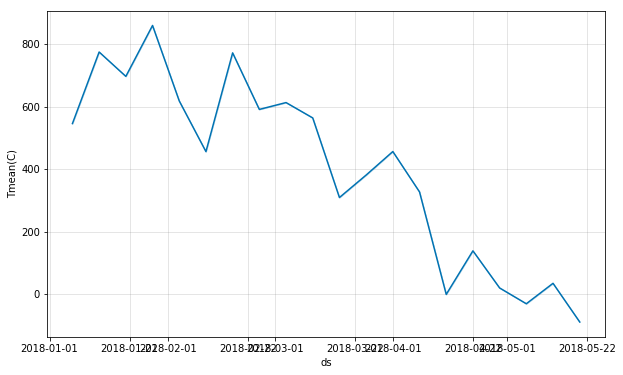

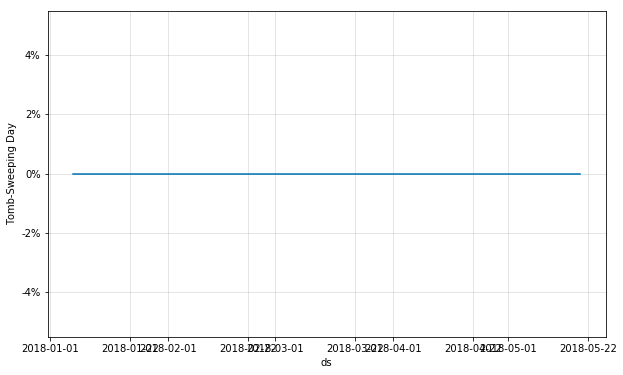

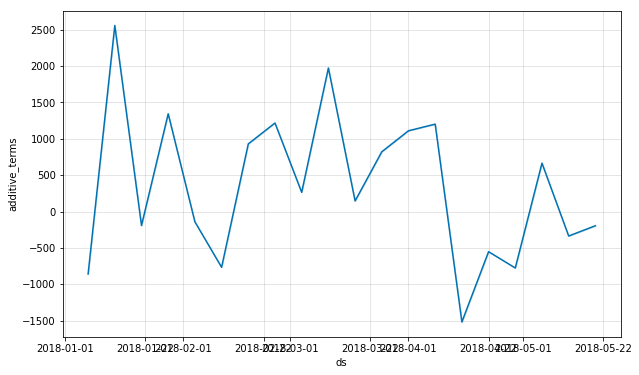

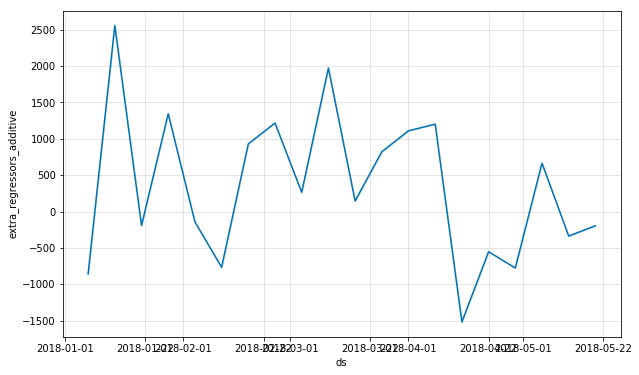

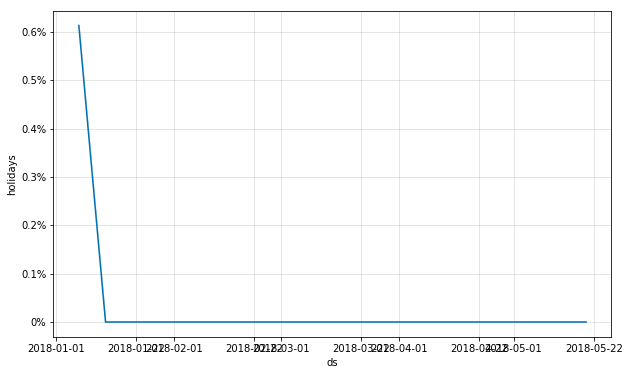

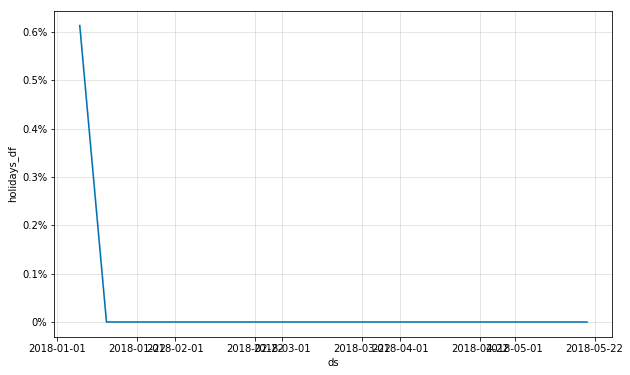

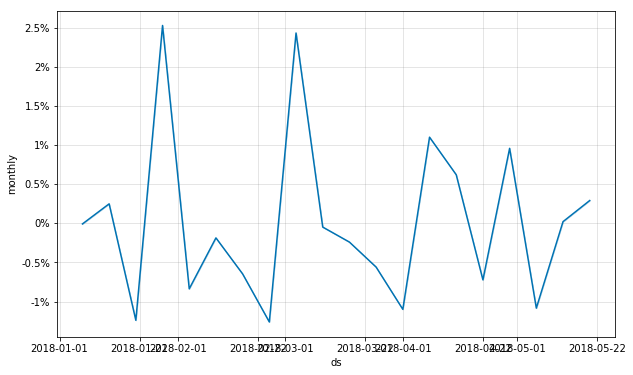

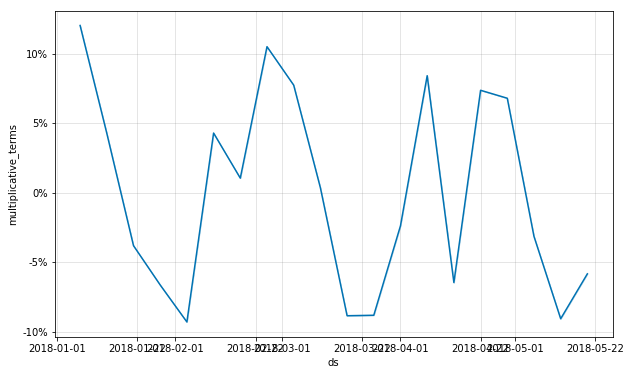

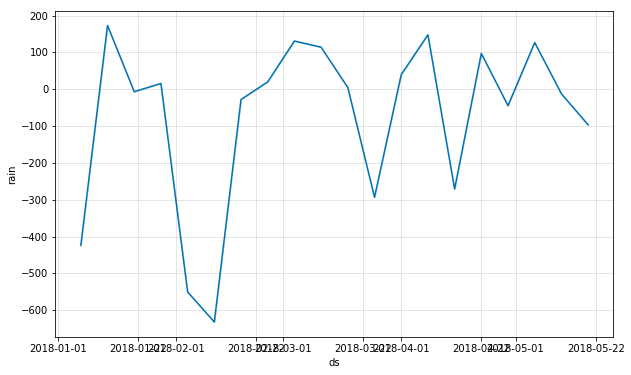

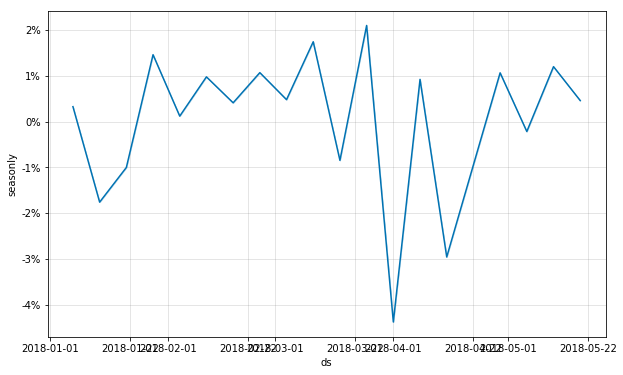

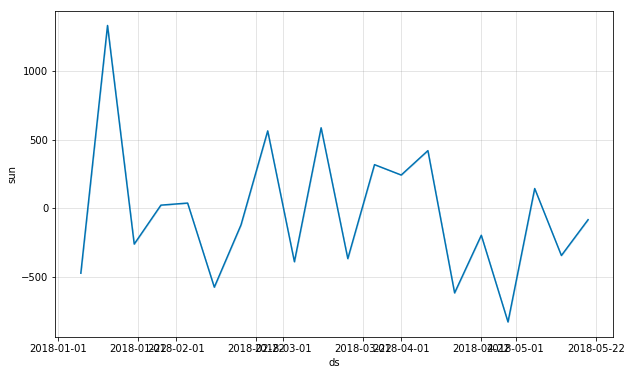

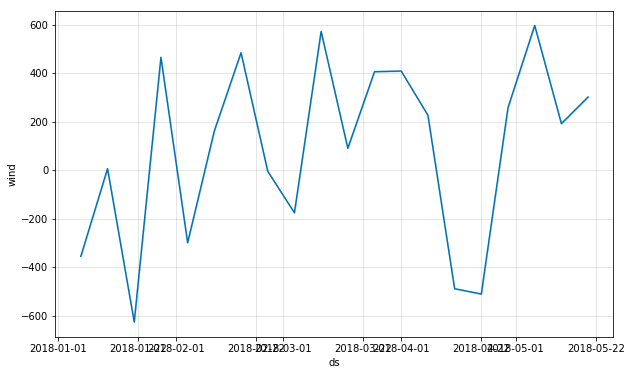

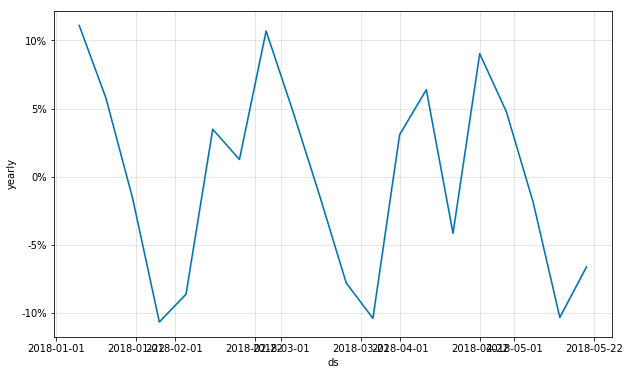

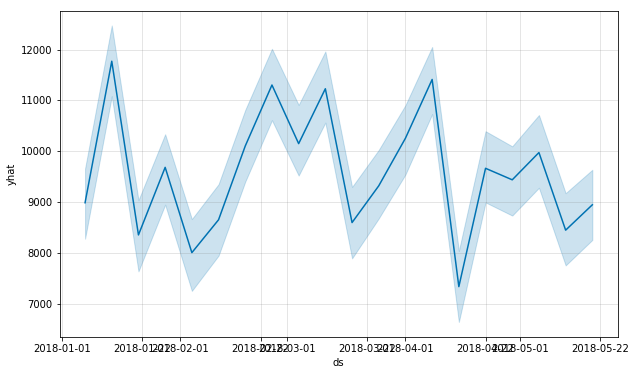

In [17]:
def prophet_func_221(pp_date=data_train_week['ds'].max(), original_data=data_train_week, fc=fc, holiday=holidays_df,
                     relative_data_1_train=tempt_train_week, relative_data_2_train=RH_train_week, 
                     relative_data_3_train=rain_train_week, relative_data_4_train=sun_train_week, 
                     relative_data_5_train=wind_train_week,
                     relative_data_1_test=tempt_test_week, relative_data_2_test=RH_test_week, 
                     relative_data_3_test=rain_test_week, relative_data_4_test=sun_test_week, 
                     relative_data_5_test=wind_test_week):
    '''
    prophet预测，节假日项、季节项以乘法方式进入模型，相关变量以加法方式进入模型。
    '''

    # 设置模型参数。“1”表示对应项以加法方式进入模型，“2”表示对应项以乘法方式进入模型。
    m221 = Prophet(holidays=holiday, holidays_prior_scale=0.25, changepoint_prior_scale=0.01,
                   seasonality_mode='multiplicative', yearly_seasonality=False, weekly_seasonality=False,
                   daily_seasonality=False)
    # 内置固定及移动节假日
    m221.add_country_holidays(country_name='CN')
    # 设置多重季节性
    m221.add_seasonality(name='yearly', period=365/7, fourier_order=6, prior_scale=0.1, mode='multiplicative')
    m221.add_seasonality(name='seasonly', period=365/4/7, fourier_order=5, prior_scale=0.1, mode='multiplicative')
    m221.add_seasonality(name='monthly', period=365/12/7, fourier_order=4, prior_scale=0.1, mode='multiplicative')
    # 设置add_regressor中相关变量信息但不赋值
    m221.add_regressor(relative_data_1_train.columns[1], prior_scale=0.03, mode='additive')
    m221.add_regressor(relative_data_2_train.columns[1], prior_scale=0.03, mode='additive')
    m221.add_regressor(relative_data_3_train.columns[1], prior_scale=0.03, mode='additive')
    m221.add_regressor(relative_data_4_train.columns[1], prior_scale=0.03, mode='additive')
    m221.add_regressor(relative_data_5_train.columns[1], prior_scale=0.03, mode='additive')
    # 拟合及预测数据
    datestamp = pd.date_range(end=pp_date, periods=len(original_data))
    df_train = pd.DataFrame({'ds': datestamp, 'y': original_data['y'],
                             relative_data_1_train.columns[1]: relative_data_1_train[relative_data_1_train.columns[1]],
                             relative_data_2_train.columns[1]: relative_data_2_train[relative_data_2_train.columns[1]],
                             relative_data_3_train.columns[1]: relative_data_3_train[relative_data_3_train.columns[1]],
                             relative_data_4_train.columns[1]: relative_data_4_train[relative_data_4_train.columns[1]],
                             relative_data_5_train.columns[1]: relative_data_5_train[relative_data_5_train.columns[1]],
                             }) # 构造完整训练集df_train
    m221.fit(df_train)
    future = m221.make_future_dataframe(periods=fc, freq='1W', include_history=False)
    future221 = pd.concat([future, relative_data_1_test[relative_data_1_test.columns[1]],
                           relative_data_2_test[relative_data_2_test.columns[1]],
                           relative_data_3_test[relative_data_3_test.columns[1]],
                           relative_data_4_test[relative_data_4_test.columns[1]],
                           relative_data_5_test[relative_data_5_test.columns[1]]], axis=1) # 构造完整测试集future221
    forecast221 = m221.predict(future221)
    # 输出图形及数值预测结果
    fig1 = m221.plot(forecast221)
    fig2 = m221.plot_components(forecast221)
    for i in range(6, 67, 3):
        plot_forecast_component(m221, forecast221, forecast221.columns[i])

    prophet_amou = forecast221['yhat'].values
    trend_amou = forecast221['trend'].values
    holiday_amou = forecast221['holidays'].values
    seasonality_amou = forecast221['yearly'].values + forecast221['seasonly'].values + forecast221['monthly'].values
    relative_amou = forecast221['extra_regressors_additive'].values
    
    if False not in (prophet_amou - (trend_amou * (1+holiday_amou+seasonality_amou) + relative_amou) < 1e-10):
        prophet_amou_1 = prophet_amou
        trend_amou_1 = trend_amou
        holiday_amou_1 = holiday_amou
        seasonality_amou_1 = seasonality_amou
        relative_amou_1 = relative_amou    
        prophet_amou_1 = [0 if i < 0 else i for i in prophet_amou_1] # 只有prophet_amou_1的负值预测需用0代替，其余不能。
        return prophet_amou_1, trend_amou_1, holiday_amou_1, seasonality_amou_1, relative_amou_1
    else: 
        return None

predict_result = []
predict_result = prophet_func_221()
predict_result


In [18]:
print('共耗时：{0}分钟'.format((time.clock()-t0)/60))

共耗时：2.1406876833333333分钟
